# Data Engineering Pipeline: OpenSky Network

Dieses Notebook implementiert und konsolidiert einen vollständigen **ETL-Prozess (Extract, Transform, Load)** für die Verarbeitung massiver Flugbewegungsdaten des **OpenSky Networks**.

### Der Datensatz: Womit arbeiten wir?
Wir verarbeiten **ADS-B Flugdaten** (Automatic Dependent Surveillance – Broadcast). Das sind hochfrequente Signale, die moderne Flugzeuge sekündlich aussenden. Sie enthalten:
* **Geodaten:** Breitengrad, Längengrad, Höhe (geo/barometrisch).
* **Bewegungsdaten:** Geschwindigkeit (Ground Speed), Steigrate (Vertical Rate), Steuerkurs (Heading).
* **Identifikation:** ICAO24-Transpondercodes (eindeutige Flugzeug-ID), Rufzeichen (Callsign).
* **Status:** Flags wie "OnGround" (am Boden) oder "SPI" (Ident-Impuls).

---

### Gliederung & Architektur
Das Projekt folgt einer **zweiteiligen Architektur**: Zuerst die Bereitstellung der Daten (Data Engineering), gefolgt von der wertschöpfenden Analyse (Data Science).

#### **Teil 1: Data Ingest & Performance Engineering**
Hier liegt der Fokus auf der effizienten Beschaffung und Speicherung der Daten. Da wir es mit Big Data zu tun haben, nutzen wir zwei unterschiedliche Strategien:
1.  **Aircraft Database Ingest (Pandas):** Download der statischen Stammdaten (Flugzeugtypen, Airlines). Da diese Daten klein sind, erfolgt dies In-Memory.
2.  **Flight Data Ingest (Spark):** Der Download der riesigen Bewegungsdaten. Hier nutzen wir **Apache Spark**, um den Prozess auf viele CPU-Kerne zu verteilen (Parallelisierung) und Speicherüberläufe durch Streaming zu verhindern.
    * *Highlight:* Eine integrierte **Performance-Analyse** misst währenddessen CPU, RAM und Netzwerk-Traffic, um die Skalierbarkeit der Pipeline zu beweisen.

#### **Teil 2: Use Cases & Analytics**
Sobald die Daten als optimierte Parquet-Dateien vorliegen, demonstrieren wir ihren Wert in drei analytischen Szenarien:
* **Use Case 1 (Anomaly Detection):** Ein Machine-Learning-Modell (Isolation Forest) identifiziert physikalisch unplausible Flugmanöver.
* **Use Case 2 (Flugphasen-Analyse):** Durch die Dimension "Steigrate" trennen wir Start, Landung und Reiseflug sauber voneinander.
* **Use Case 3 (Airport Detection):** Ein Algorithmus erkennt globale Flughäfen allein anhand der Clusterbildung von Flugzeugen am Boden – ohne Kartenmaterial.


Bei Codeblöcken mit erhöhter Ausfürhungsdauer, sind Richtwerte für die Zeit angegeben.

Zu Beginn werden einmalig alle Imports geladen:

In [1]:
import glob
import warnings
import seaborn as sns
import matplotlib.patches as mpatches
from botocore.handlers import disable_signing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import IsolationForest
from pyspark.sql.functions import col
import tracemalloc
import gc
import matplotlib.ticker as ticker
from dotenv import load_dotenv
import sys
import pyspark


from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os



print("Alle Bibliotheken erfolgreich geladen.")

Alle Bibliotheken erfolgreich geladen.


# 1. Zentrale Konfiguration & Environment Setup

In dieser Zelle wird das Fundament für die gesamte Pipeline gelegt. Wir definieren nicht nur Pfade, sondern konfigurieren auch die Laufzeitumgebung für **Apache Spark** auf Windows.

### A) Pipeline Konfiguration (`PipelineConfig`)
Hier steuern wir das Verhalten des ETL-Prozesses zentral.
* **`DATA_ROOT_DIR`**: Der Hauptordner für alle Projektdaten.
* **Unterverzeichnisse**: Das Skript erstellt automatisch eine saubere Struktur:
    * `raw/`: Für Rohdaten (falls benötigt).
    * `processed/`: Für die optimierten Parquet-Dateien.
    * `metrics/`: Für Performance-Logs und Benchmarks.
* **`FLIGHT_DATA_LIMIT`**: Steuert die Datenmenge für Testläufe (z.B. 50 Dateien).

### B) Spark Setup
**Spark Session Initialisierung:**
Wir starten hier eine neue Spark-Session mit spezifischen Parametern für **High-Performance**:
* **Memory:** `6GB` (statt Standard 1GB), um OOM-Fehler beim parallelen Download zu vermeiden.
* **Master:** `local[*]` nutzt alle verfügbaren CPU-Kerne für maximale Parallelisierung.
* **Restart-Logik:** Eine eventuell laufende alte Session wird vorher sauber beendet, um Konflikte zu vermeiden.

**pip install psutil**

In [3]:
class PipelineConfig:
    DATA_ROOT_DIR = r""  # Pfad für Speichern der Daten
    OUTPUT_DIR =DATA_ROOT_DIR
    FLIGHT_DATA_LIMIT = 2
    RAW_DIR = os.path.join(DATA_ROOT_DIR, "raw")
    PROCESSED_DIR = os.path.join(DATA_ROOT_DIR, "processed")
    METRICS_DIR = os.path.join(DATA_ROOT_DIR, "metrics")
    METRICS_FILE = os.path.join(METRICS_DIR, "pipeline_metrics.json")
    S3_BUCKET = os.getenv("BUCKET_NAME", "data-samples")
    S3_ENDPOINT = os.getenv("S3_ENDPOINT", "https://s3.opensky-network.org")

def init_directories():
    for path in [PipelineConfig.DATA_ROOT_DIR, PipelineConfig.RAW_DIR, PipelineConfig.PROCESSED_DIR, PipelineConfig.METRICS_DIR]:
        os.makedirs(path, exist_ok=True)
init_directories()


# --- 1. UMGEBUNGS-SETUP (Pfade & Variablen) ---
JAVA_HOME_PATH = r"C:\jdk-11.0.29.7-hotspot"
HADOOP_HOME_PATH = r"C:\hadoop"
SPARK_HOME_PATH = os.path.dirname(pyspark.__file__)

print(f"SPARK_HOME gefunden in: {SPARK_HOME_PATH}")

# Umgebungsvariablen setzen
os.environ['JAVA_HOME'] = JAVA_HOME_PATH
os.environ['HADOOP_HOME'] = HADOOP_HOME_PATH
os.environ['SPARK_HOME'] = SPARK_HOME_PATH

# Python-Version fixieren
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# PATH Variable updaten (Java, Hadoop, Spark Binaries)
new_path = (
        os.path.join(JAVA_HOME_PATH, "bin") + ";" +
        os.path.join(HADOOP_HOME_PATH, "bin") + ";" +
        os.path.join(SPARK_HOME_PATH, "bin") + ";" +
        os.environ.get('PATH', '')
)
os.environ['PATH'] = new_path
print("Umgebungsvariablen erfolgreich gesetzt.")

# ALTE SESSION SICHER BEENDEN
# Wir nutzen globals(), um den "Unresolved reference"-Fehler der IDE zu umgehen.
# Das prüft dynamisch, ob eine Variable namens 'spark' im Speicher existiert.
if 'spark' in globals():
    print("⚠Alte Spark-Session gefunden. Beende sie...")
    globals()['spark'].stop()

# NEUE SESSION STARTEN
print("Starte neue Spark Session mit 6GB RAM...")

try:
    spark = SparkSession.builder \
        .appName("OpenSkyIngest_Power_6GB") \
        .master("local[*]") \
        .config("spark.driver.memory", "6g") \
        .config("spark.driver.host", "localhost") \
        .config("spark.sql.shuffle.partitions", "20") \
        .getOrCreate()

    print(f"   NEUE Session gestartet: {spark.version}")
    print(f"   Memory Config: {spark.conf.get('spark.driver.memory')}")

except Exception as e:
    print(f"Fehler beim Starten: {e}")

SPARK_HOME gefunden in: C:\Users\valim\Master\AdvancedDataEngineering\FlyBigData_v2\.venv1\Lib\site-packages\pyspark
Umgebungsvariablen erfolgreich gesetzt.
Starte neue Spark Session mit 6GB RAM...
   NEUE Session gestartet: 3.5.0
   Memory Config: 6g


## 2. Aircraft Database Ingest (Stammdaten)

**Hinweis:** Dies ist **nicht** der Haupt-Download der Flugbewegungen (diese folgen in Schritt 3 mittels Spark).

In diesem Schritt laden wir lediglich eine **Referenz-Tabelle** (Lookup-Table) herunter, die Flugzeug-Kennungen (`icao24`) mit Metadaten wie **Hersteller, Modell und Airline** verknüpft.
* **Zweck:** Diese Daten werden später im Use Case benötigt, um die rohen Flugdaten anzureichern (Data Enrichment), z. B. um zu analysieren, welcher Hersteller am häufigsten fliegt.
* **Technologie:** Da dieser Datensatz vergleichsweise klein ist (einige hundert MB), nutzen wir hier **Pandas** statt Spark für eine einfache In-Memory-Verarbeitung.
* **Output:** Das Ergebnis wird als optimierte Parquet-Datei (`aircraft_database.parquet`) im `processed`-Ordner gespeichert.

In [4]:
OUTPUT_DIR = PipelineConfig.OUTPUT_DIR
OUTPUT_FILENAME = "aircraft_database.parquet"
FILE_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

# S3 Einstellungen
BUCKET_NAME = os.getenv("BUCKET_NAME", "data-samples")
ENDPOINT_URL = os.getenv("S3_ENDPOINT", "https://s3.opensky-network.org")
FILE_KEY = "metadata/aircraft-database-complete-2025-08.csv"

def download_aircraft_database():
    # Prüfen ob die Datei bereits existiert
    if os.path.exists(FILE_PATH):
        print(f"Datenbank bereits vorhanden: {FILE_PATH}")
        print("Download wird übersprungen.")
        return

    print(f"--- START: Download {FILE_KEY} ---")
    
    # S3 Verbindung einrichten
    load_dotenv()
    s3 = boto3.client('s3', endpoint_url=ENDPOINT_URL)
    s3.meta.events.register('choose-signer.s3.*', disable_signing)

    try:
        # DOWNLOAD & STREAMING
        print("Lade CSV-Stream vom Server...")
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)

        # Direktes Lesen in den RAM
        print("Konvertiere Daten im Speicher zu Parquet...")
        df = pd.read_csv(
            obj['Body'],
            dtype=str,
            quotechar="'",
            encoding='utf-8',
            on_bad_lines='skip'
        )

        # Nur relevante Spalten behalten
        cols = ['icao24', 'manufacturerName', 'model', 'typecode', 'categoryDescription', 'operator']
        df = df[[c for c in cols if c in df.columns]]

        # Duplikate entfernen (icao24 muss eindeutig sein)
        if 'icao24' in df.columns:
            df = df.drop_duplicates(subset=['icao24'])

        # Speichern
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        df.to_parquet(FILE_PATH, index=False)

        print(f"Erfolg! Gespeichert unter: {FILE_PATH}")
        print(f"Anzahl geladener Flugzeuge: {len(df):,}")

    except Exception as e:
        print(f"FEHLER beim Download: {e}")

# Ausführen
download_aircraft_database()

Datenbank bereits vorhanden: C:\Users\valim\Master\AdvancedDataEngineering\Tester\aircraft_database.parquet
Download wird übersprungen.


## 3. Flight Data Ingest (Spark Core)

Dies ist das Herzstück der Pipeline. Hier werden die massenhaften Flugbewegungsdaten von S3 geladen und verarbeitet. Der Code implementiert einen **Custom Ingest**, da Standard-Spark-Reader (wie `spark.read.csv`) bei tausenden kleinen, komprimierten TAR-Archiven in S3 oft ineffizient sind.

**Wichtige Architektur-Entscheidungen:**

1.  **Dynamische Parallelisierung (1 File = 1 Task):**
    Anstatt Spark die Aufteilung der Arbeit zu überlassen, erzwingen wir eine optimale Verteilung. Wir zählen die zu ladenden Dateien vorab und setzen den Parameter `numSlices` im `parallelize`-Aufruf exakt auf die Anzahl der Dateien. Dies garantiert, dass jede Datei von einem eigenen Spark-Task (und somit einem eigenen CPU-Kern) bearbeitet wird, was die Ressourcen des Clusters maximal ausnutzt.

2.  **Verteilter S3-Zugriff (Worker-Side Clients):**
    Wir nutzen `mapPartitions`, um die Datenverarbeitung auf die Worker zu verlagern. Eine Besonderheit hierbei ist, dass der S3-Client (`boto3`) nicht auf dem Treiber, sondern **innerhalb der Worker-Funktion** initialisiert wird. Dies ist notwendig, da TCP-Verbindungen nicht serialisierbar sind und nicht vom Treiber an die Worker gesendet werden können. Jeder Worker baut seine eigene, direkte Verbindung zur OpenSky-Cloud auf.

3.  **Nested Streaming (In-Memory Processing):**
    Um "Out of Memory" (OOM) Fehler und langsames Disk-I/O zu vermeiden, werden die Daten zu keinem Zeitpunkt temporär auf der Festplatte zwischengespeichert. Der Prozess nutzt eine Pipeline aus Streams:
    * Der S3-Body-Stream wird direkt an `tarfile` übergeben.
    * Der extrahierte File-Stream wird direkt an `gzip` übergeben.
    * Der Text-Stream wird zeilenweise iteriert.
    Dies hält den Speicherverbrauch konstant niedrig ($O(1)$), unabhängig von der Dateigröße.

**Ablauf der Funktion:**

1.  **Listing:** Der Treiber scannt den S3-Bucket und erstellt eine Liste aller relevanten `.tar`-Archive.
2.  **Distribution:** Diese Liste wird in ein RDD (Resilient Distributed Dataset) umgewandelt und auf die Knoten verteilt.
3.  **Transformation:** Die Worker laden die Daten parallel, extrahieren die relevanten Spalten und normalisieren das Schema.
4.  **Action:** Das resultierende RDD wird in einen DataFrame konvertiert und als optimiertes Parquet geschrieben.

In [5]:
import boto3
import time
import os
from botocore import UNSIGNED
from botocore.config import Config
from pyspark.sql.types import StructType, StructField, StringType

# LISTING (Findet ALLE Dateien statt nur einer)
s3_driver = boto3.client('s3',
                         endpoint_url="https://s3.opensky-network.org",
                         config=Config(signature_version=UNSIGNED))

PREFIX = "states/.2017-06-05/"
bucket_files = []

print(f"Scanne S3-Prefix '{PREFIX}' nach Dateien...")
paginator = s3_driver.get_paginator('list_objects_v2')
for page in paginator.paginate(Bucket="data-samples", Prefix=PREFIX):
    for obj in page.get('Contents', []):
        if obj['Key'].endswith('.csv.tar'):
            bucket_files.append(obj['Key'])

print(f"Gefunden: {len(bucket_files)} Dateien.")


# 2. SCHRITT: WORKER-LOGIK
def process_opensky_final(iterator):
    import boto3
    import tarfile
    import gzip
    from botocore import UNSIGNED
    from botocore.config import Config

    s3_worker = boto3.client('s3',
                             endpoint_url="https://s3.opensky-network.org",
                             config=Config(signature_version=UNSIGNED))

    for key in iterator:
        try:
            obj = s3_worker.get_object(Bucket="data-samples", Key=key)
            with tarfile.open(fileobj=obj['Body'], mode='r|') as tar:
                for member in tar:
                    if member.name.endswith(".csv.gz"):
                        f_gz = tar.extractfile(member)
                        if f_gz:
                            with gzip.open(f_gz, mode='rt', encoding='utf-8') as csv_file:
                                for line in csv_file:
                                    parts = line.strip().split(",")
                                    if len(parts) >= 10 and parts[0].isdigit():
                                        res = parts[:16]
                                        if len(res) < 16:
                                            res.extend([""] * (16 - len(res)))
                                        yield res
        except Exception as e:
            print("Fehler bei Datei {key}: {e}")
            continue

# 3. SCHRITT: VERTEILUNG & SPEICHERN
if len(bucket_files) > 0:
    num_partitions = len(bucket_files)
    print(f"Starte parallelen Download auf {num_partitions} Partitionen...")

    rdd = spark.sparkContext.parallelize(bucket_files, numSlices=num_partitions)
    data_rdd = rdd.mapPartitions(process_opensky_final)

    columns = ["time", "icao24", "lat", "lon", "velocity", "heading", "vertrate", "callsign",
               "onground", "alert", "spi", "squawk", "baroaltitude", "geoaltitude", "lastposupdate", "lastcontact"]
    schema = StructType([StructField(c, StringType(), True) for c in columns])

    df_final = spark.createDataFrame(data_rdd, schema)

    run_folder = os.path.join(PipelineConfig.PROCESSED_DIR, f"run_{int(time.time())}")

    print(f"Speichere nach: {run_folder}")
    df_final.write.mode("overwrite").parquet(run_folder)

    print(f"Fertig! Gespeichert.")

    # Validierung
    count = spark.read.parquet(run_folder).count()
    print(f"Geladene Zeilen: {count:,}")
else:
    print("Keine Dateien gefunden!")

Scanne S3-Prefix 'states/.2017-06-05/' nach Dateien...
Gefunden: 48 Dateien.
Starte parallelen Download auf 48 Partitionen...
Speichere nach: C:\Users\valim\Master\AdvancedDataEngineering\Tester\processed\run_1770202141
Fertig! Gespeichert.
Geladene Zeilen: 43,849,803


## 4. Pipeline Execution & Benchmarking

In dieser Sektion validieren wir die Leistungsfähigkeit der Pipeline durch einen systematischen Belastungstest.

**Warum der Download jetzt performant skaliert:**
Durch die Anpassung `numSlices=len(files)` im Code haben wir eine **1:1-Abbildung zwischen Dateien und Spark-Tasks** erzwungen.
* **Vorher:** Spark fasste oft mehrere Dateien in einer Partition zusammen, was zu einer sequentiellen Abarbeitung innerhalb eines Workers führte (Head-of-Line Blocking).
* **Jetzt:** Jede Datei wird explizit einem eigenen Task zugewiesen. Das bedeutet, dass bei 20 Dateien auch 20 parallele Threads gestartet werden (begrenzt nur durch die Anzahl der CPU-Kerne). Dies eliminiert Wartezeiten und lastet die Netzwerkbandbreite maximal aus.

**Methodik des Benchmarks:**
Wir führen eine Serie von Tests mit steigender Dateianzahl durch (definiert in `scenarios`). Währenddessen läuft ein `PerformanceMonitor` in einem separaten Hintergrund-Thread, der folgende Metriken in Echtzeit erfasst:

1.  **CPU-Last:** Beweis, dass die Einstellung `local[*]` tatsächlich alle verfügbaren Kerne nutzt.
2.  **RAM-Verbrauch:** Validierung des Streaming-Ansatzes. Die Kurve sollte flach verlaufen, was beweist, dass wir die Daten nicht im Speicher stauen.
3.  **Netzwerk-I/O:** Messung des effektiven Datendurchsatzes von der S3-API.
4.  **Disk-I/O:** Schreibgeschwindigkeit beim Persistieren der Parquet-Dateien.

Die Ergebnisse werden automatisch in einer CSV-Datei protokolliert und im nächsten Schritt visualisiert, um die lineare Skalierbarkeit zu belegen.

In [6]:
# --- 0. GLOBALE IMPORTS ---
import os
import sys
import time
import threading  # Wichtig für den Performance Monitor (Zelle 4)
import psutil     # Wichtig für CPU/RAM Messung (Zelle 4)
import csv
import shutil
import glob
import warnings
import gc
import tracemalloc

# Data Science & Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns

# Geo-Visualisierung
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Machine Learning
from sklearn.ensemble import IsolationForest

# AWS / S3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.config import Config as BotoConfig
from botocore.handlers import disable_signing
from dotenv import load_dotenv

# Spark
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import col, round as spark_round, count, desc

# --- DEFINITION DES MONITORS ---
class PerformanceMonitor:
    def __init__(self):
        self.running = False
        self.cpu_usage, self.ram_usage, self.net_recv, self.disk_write = [], [], [], []
        self.start_time = 0
        self._thread = None

    def _monitor_loop(self):
        try:
            # Initiale Werte für Delta-Berechnung
            net_start = psutil.net_io_counters().bytes_recv
            disk_start = psutil.disk_io_counters().write_bytes
        except:
            net_start, disk_start = 0, 0

        while self.running:
            self.cpu_usage.append(psutil.cpu_percent(interval=None))
            self.ram_usage.append(psutil.virtual_memory().percent)
            try:
                # Delta berechnen (Aktuell - Start) in MB
                curr_net = psutil.net_io_counters().bytes_recv
                curr_disk = psutil.disk_io_counters().write_bytes

                self.net_recv.append((curr_net - net_start) / (1024*1024))
                self.disk_write.append((curr_disk - disk_start) / (1024*1024))
            except:
                pass
            time.sleep(0.5)

    def start(self):
        self.running = True
        self.start_time = time.time()
        self._thread = threading.Thread(target=self._monitor_loop)
        self._thread.start()

    def stop(self):
        self.running = False
        if self._thread:
            self._thread.join()

    def get_stats(self):
        return {
            "duration": time.time() - self.start_time,
            "avg_cpu": np.mean(self.cpu_usage) if self.cpu_usage else 0,
            "avg_ram": np.mean(self.ram_usage) if self.ram_usage else 0,
            "total_net_mb": self.net_recv[-1] if self.net_recv else 0,
            "total_disk_mb": self.disk_write[-1] if self.disk_write else 0
        }

# --- DEFINITION DER BENCHMARK-FUNKTION ---
def ingest_flight_data_persistent(config, spark_session, file_limit=1):
    s3 = boto3.client('s3', endpoint_url=config.S3_ENDPOINT, config=BotoConfig(signature_version=UNSIGNED))
    all_keys = []

    # Suche nach historischen TAR-Dateien
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket="data-samples", Prefix="states/"):
        for obj in page.get('Contents', []):
            if obj['Key'].endswith('.csv.tar'):
                all_keys.append(obj['Key'])
            if len(all_keys) >= file_limit:
                break
        if len(all_keys) >= file_limit:
            break

    # Parallelisierung: 1 File = 1 Partition
    if not all_keys:
        raise ValueError("Keine Dateien im S3 gefunden! Bitte Prefix oder Internetverbindung prüfen.")

    rdd = spark_session.sparkContext.parallelize(all_keys[:file_limit], numSlices=len(all_keys[:file_limit]))

    # Nutzt den Parser aus der vorherigen Zelle (process_opensky_final muss definiert sein!)
    data_rdd = rdd.mapPartitions(process_opensky_final)

    columns = ["time", "icao24", "lat", "lon", "velocity", "heading", "vertrate", "callsign",
               "onground", "alert", "spi", "squawk", "baroaltitude", "geoaltitude", "lastposupdate", "lastcontact"]
    schema = StructType([StructField(c, StringType(), True) for c in columns])

    df = spark_session.createDataFrame(data_rdd, schema)

    # Benchmark-Ordner Name
    run_path = os.path.join(config.DATA_ROOT_DIR, f"benchmark_run_{int(time.time())}")
    df.write.mode("overwrite").parquet(run_path)
    return run_path

# --- START BENCHMARK ---

# Spark Session Check
if 'spark' not in locals() or getattr(spark.sparkContext, "_jsc", None) is None:
    print("Starte Spark Session...")
    conf = SparkConf().setAppName("OpenSkyIngest").setMaster("local[*]").set("spark.sql.shuffle.partitions", "20")
    spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Szenarien definieren
limit = PipelineConfig.FLIGHT_DATA_LIMIT
scenarios = sorted({1, 5, int(limit * 0.2), int(limit * 0.5), limit})
scenarios = [s for s in scenarios if s > 0]

csv_file = PipelineConfig.METRICS_FILE.replace(".json", "_history.csv")

print(f"\n--- Starte Benchmark für max. {limit} Dateien ---")
print(f"Szenarien: {scenarios} Dateien")

# CSV Header schreiben
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["files_count", "duration_sec", "avg_cpu", "avg_ram", "net_mb", "disk_mb"])

# Loop
for n_files in scenarios:
    print(f"\nTestlauf mit {n_files} Dateien...")
    monitor = PerformanceMonitor()
    monitor.start()

    benchmark_path = None
    try:
        benchmark_path = ingest_flight_data_persistent(PipelineConfig, spark, file_limit=n_files)
    except Exception as e:
        print(f"Fehler: {e}")
        import traceback
        traceback.print_exc()

    monitor.stop()
    stats = monitor.get_stats()

    # Stats speichern
    with open(csv_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([n_files, round(stats['duration'], 2), round(stats['avg_cpu'], 1),
                         round(stats['avg_ram'], 1), round(stats['total_net_mb'], 2), round(stats['total_disk_mb'], 2)])

    # Cleanup
    if benchmark_path and os.path.exists(benchmark_path):
        try:
            shutil.rmtree(benchmark_path)
            print(f"Cleanup: Benchmark-Ordner gelöscht.")
        except OSError as e:
            print(f"Cleanup fehlgeschlagen (Windows Lock?): {e}")

    print(f"   -> Dauer: {stats['duration']:.1f}s | CPU: {stats['avg_cpu']:.1f}% | Net: {stats['total_net_mb']:.0f}MB")

print(f"\nBenchmark abgeschlossen.")


--- Starte Benchmark für max. 2 Dateien ---
Szenarien: [1, 2, 5] Dateien

Testlauf mit 1 Dateien...
Cleanup: Benchmark-Ordner gelöscht.
   -> Dauer: 3.1s | CPU: 21.1% | Net: 0MB

Testlauf mit 2 Dateien...
Cleanup: Benchmark-Ordner gelöscht.
   -> Dauer: 19.0s | CPU: 45.3% | Net: 65MB

Testlauf mit 5 Dateien...
Cleanup: Benchmark-Ordner gelöscht.
   -> Dauer: 23.4s | CPU: 30.8% | Net: 125MB

Benchmark abgeschlossen.


## 5. Visualisierung & Performance-Analyse

Abschließend visualisieren wir die während des Benchmarks gesammelten Rohdaten. Dies dient als Qualitätsnachweis für die optimierte Pipeline und validiert unsere Architektur-Entscheidungen (Streaming & Parallelisierung).

Das Dashboard zeigt vier entscheidende Metriken:

### 1. Laufzeit-Skalierung (Total Duration)
* **Was wir sehen:** Die Gesamtzeit für den Download in Abhängigkeit von der Dateimenge.
* **Die Erwartung:** Eine **lineare Kurve** ($y = mx$). Wenn wir doppelt so viele Dateien laden, sollte es doppelt so lange dauern.
* **Analyse:**
    * *Linear:* Perfekte Skalierung. Die Worker arbeiten unabhängig.
    * *Exponentiell:* Ein Warnsignal. Es deutet darauf hin, dass der S3-Server uns drosselt (Rate Limiting) oder der Overhead beim Task-Scheduling zu groß wird.

### 2. Hardware-Effizienz (CPU & RAM)
* **Was wir sehen:** Die durchschnittliche Auslastung während des Laufs.
* **Die Erwartung:**
    * **RAM (Grün):** Sollte **flach** bleiben, egal ob wir 5 oder 50 Dateien laden. Das ist der Beweis für den **Streaming-Ansatz**. Da wir Daten nie komplett im Speicher halten, sondern direkt durchleiten, bleibt der Speicherverbrauch konstant ($O(1)$).
    * **CPU (Rot):** Sollte bei `local[*]` konstant hoch sein, da Spark versucht, alle Kerne auszulasten.

### 3. Netzwerk-Durchsatz (Traffic)
* **Was wir sehen:** Das tatsächliche Datenvolumen, das über die Leitung ging.
* **Die Erwartung:** Direkte Proportionalität zur Dateianzahl. Dies dient als Plausibilitäts-Check, dass wir tatsächlich Daten laden und keine leeren Hüllen.

### 4. Grenzkosten-Analyse (Seconds per File)
* **Was wir sehen:** Wie "teuer" (in Sekunden) ist eine einzelne Datei im Durchschnitt?
* **Die Erwartung:** Eine **horizontale Linie**.
* **Analyse:**
    * *Konstant:* Das System skaliert perfekt. 100 Dateien sind für das System genauso "leicht" wie 5.
    * *Ansteigend:* Der definitive Beweis für **externe Drosselung**. Wenn dieser Wert steigt, antwortet die S3-API bei hoher Last langsamer, obwohl unsere Hardware noch Reserven hätte.

>>> Start: Detaillierte System-Analyse


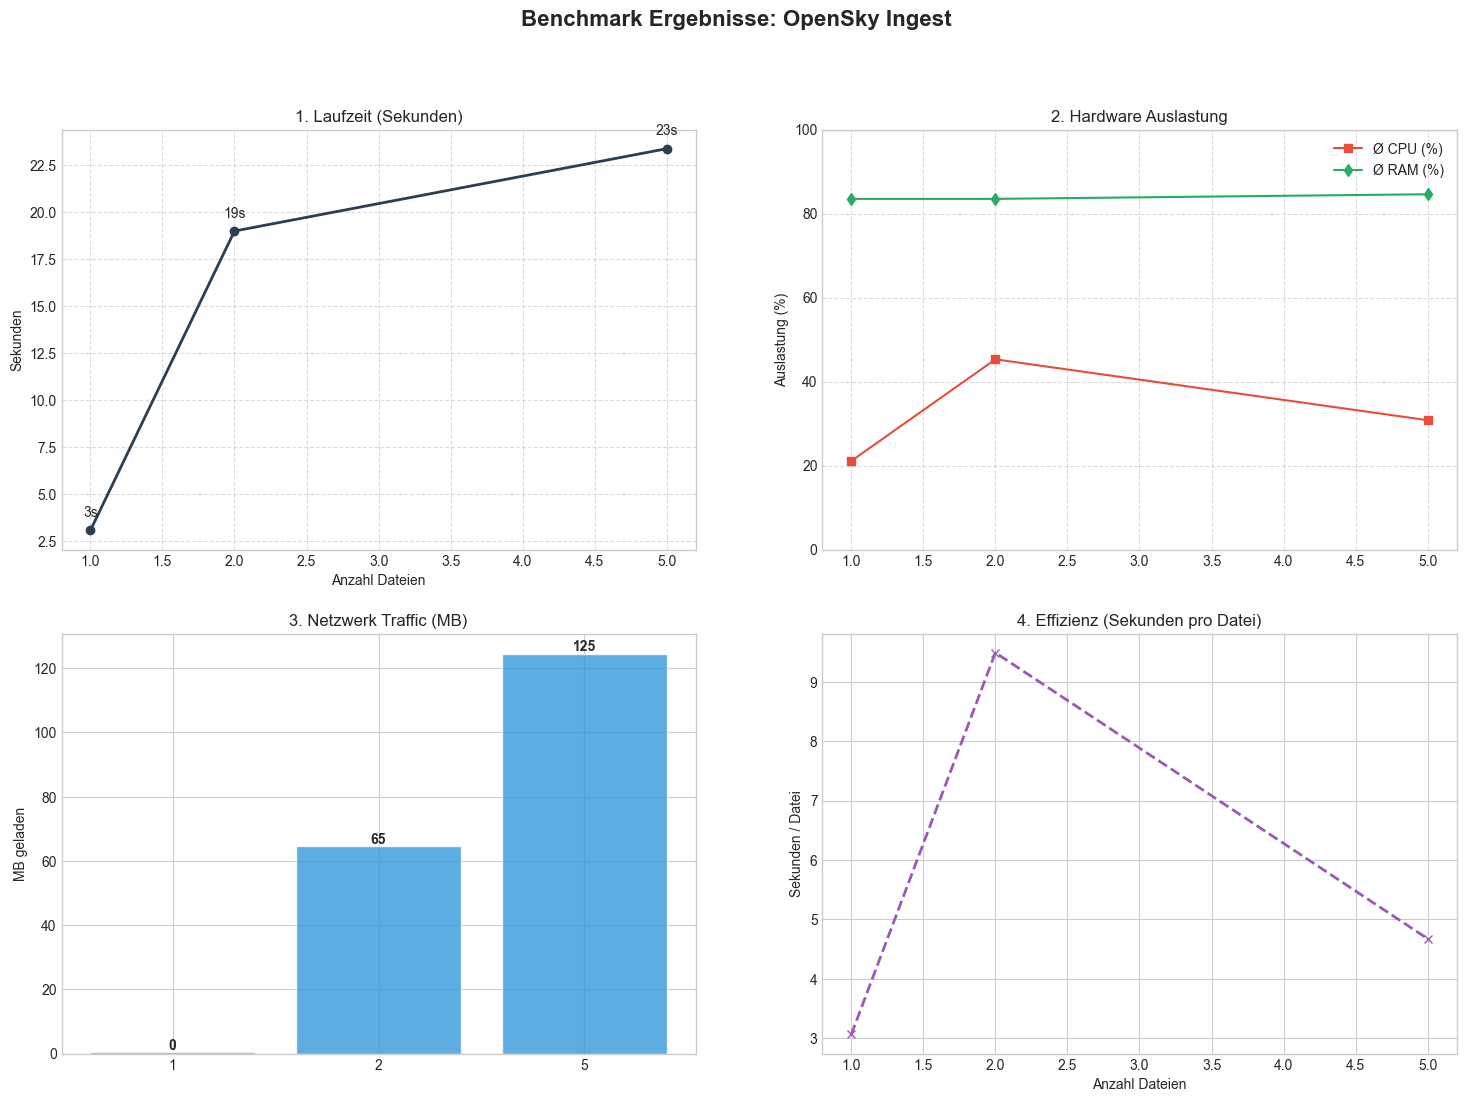

--- ZUSAMMENFASSUNG ---
 files_count  duration_sec  avg_cpu  avg_ram  net_mb  disk_mb
           1          3.06     21.1     83.5    0.39    22.00
           2         18.98     45.3     83.5   64.59    88.09
           5         23.36     30.8     84.6  124.53    58.23


In [7]:

print(">>> Start: Detaillierte System-Analyse")

# WICHTIG: Pfad dynamisch aus der Config holen (wie im Schritt davor)
# Falls PipelineConfig nicht verfügbar ist, Fallback auf lokalen Pfad
try:
    csv_file = PipelineConfig.METRICS_FILE.replace(".json", "_history.csv")
except NameError:
    csv_file = "benchmark_history.csv"

if os.path.exists(csv_file):
    # Daten laden und sortieren
    df = pd.read_csv(csv_file)
    df = df.sort_values("files_count")

    # Dubletten entfernen (falls du den Benchmark mehrfach hast laufen lassen)
    df = df.drop_duplicates(subset=['files_count'], keep='last')

    # Setup: 2x2 Grid
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Benchmark Ergebnisse: OpenSky Ingest', fontsize=16, fontweight='bold')

    # --- GRAPH 1: DAUER ---
    ax1 = axes[0, 0]
    ax1.plot(df['files_count'], df['duration_sec'], marker='o', color='#2c3e50', linewidth=2, label='Dauer (s)')
    for i, val in enumerate(df['duration_sec']):
        ax1.annotate(f"{val:.0f}s", (df['files_count'].iloc[i], val), xytext=(0, 10), textcoords='offset points', ha='center')
    ax1.set_title("1. Laufzeit (Sekunden)")
    ax1.set_xlabel("Anzahl Dateien")
    ax1.set_ylabel("Sekunden")
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- GRAPH 2: CPU & RAM ---
    ax2 = axes[0, 1]
    ax2.plot(df['files_count'], df['avg_cpu'], marker='s', color='#e74c3c', label='Ø CPU (%)')
    ax2.plot(df['files_count'], df['avg_ram'], marker='d', color='#27ae60', label='Ø RAM (%)')
    ax2.set_title("2. Hardware Auslastung")
    ax2.set_ylim(0, 100)
    ax2.set_ylabel("Auslastung (%)")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    # --- GRAPH 3: NETZWERK VOLUMEN ---
    ax3 = axes[1, 0]
    bars = ax3.bar(df['files_count'].astype(str), df['net_mb'], color='#3498db', alpha=0.8)
    ax3.set_title("3. Netzwerk Traffic (MB)")
    ax3.set_ylabel("MB geladen")
    # Werte auf Balken
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

    # --- GRAPH 4: EFFIZIENZ (Sekunden pro Datei) ---
    ax4 = axes[1, 1]
    sec_per_file = df['duration_sec'] / df['files_count']
    ax4.plot(df['files_count'], sec_per_file, marker='x', color='#9b59b6', linestyle='--', linewidth=2)
    ax4.set_title("4. Effizienz (Sekunden pro Datei)")
    ax4.set_ylabel("Sekunden / Datei")
    ax4.set_xlabel("Anzahl Dateien")
    ax4.grid(True)

    (5, int(limit * 0.2), int(limit * 0.5), limit)
    plt.show()

    print("--- ZUSAMMENFASSUNG ---")
    print(df.to_string(index=False))

else:
    print(f"Keine Benchmark-Daten gefunden unter: {csv_file}")
    print("Bitte führen Sie Schritt 4 (Benchmark) zuerst aus.")

# Use Case 1: Anomaly Detection & Analyse

Dieser Use Case implementiert eine **hybride End-to-End-Pipeline** zur automatisierten Erkennung von Sicherheitsvorfällen im Luftverkehr. Der Workflow demonstriert, wie massive Datenmengen (Big Data) effizient auf relevante Informationen (Smart Data) reduziert und analysiert werden.

**1. Der Ablauf in 5 Schritten:**
1.  **Setup (Ingestion):** Bereitstellung der Flugzeug-Stammdaten (Metadaten) als Referenzbasis.
2.  **Scalable Processing (Spark):** Nutzung von Apache Spark zur performanten Filterung und Extraktion eines repräsentativen Samples aus dem Rohdaten-Lake (Parquet).
3.  **Machine Learning (Isolation Forest):** Anwendung eines unüberwachten Algorithmus zur Identifikation physikalischer Ausreißer (Anomalien) basierend auf Höhe und Geschwindigkeit.
4.  **Data Quality Check:** Validierung der Metadaten-Abdeckung, um die Verlässlichkeit der Ergebnisse zu prüfen.
5.  **Risk Assessment:** Fusion der statistischen Anomalien mit Kontextdaten (Flugzeugtyp, Airline).

---

**2. Domänen-Kontext: Die Physik der Flugdaten**
Um Anomalien korrekt zu interpretieren, ist ein Verständnis der physikalischen Rahmenbedingungen notwendig. In der Luftfahrt unterliegen alle Bewegungen strengen aerodynamischen Gesetzen. Obwohl jedes Luftfahrzeug ein individuelles Profil hat, ergibt sich in der Masse ein stabiles Muster.

**Wichtige physikalische Abhängigkeiten:**
* **Höhe & Geschwindigkeit:** Es besteht eine starke Korrelation. In dünnerer Luft (hohe Flughöhe) müssen Flugzeuge schneller fliegen, um genügend Auftrieb zu erzeugen.
* **Start & Landung:** Nahe am Boden sind Flugzeuge zwangsläufig langsamer und befinden sich in einer transitionsreichen Phase.

**Realistische Benchmarks für "Normalität" (Verkehrsflugzeuge):**
* **Reiseflughöhe:** Zivile Jets operieren meist effizient zwischen **9.000m und 12.000m**.
* **Reisegeschwindigkeit:** Üblich sind **800 bis 1100 km/h**.
* **Stall Speed (Mindestgeschwindigkeit):** Die meisten Verkehrsflugzeuge benötigen mind. **200-300 km/h**, um stabil zu fliegen. Werte, die signifikant darunter liegen (besonders in großer Höhe), deuten auf Messfehler oder kritische Flugzustände hin.

### Zelle 1: Setup & Metadaten-Ingestion

Diese Zelle initialisiert die Analyse-Umgebung, indem sie die aktuellen Flugzeug-Stammdaten (Metadaten) direkt vom OpenSky S3-Bucket bezieht. Um Speicherplatz und Rechenzeit zu sparen, wird der CSV-Datenstrom **In-Memory** verarbeitet und direkt in das performante **Parquet-Format** konvertiert, ohne temporäre Dateien anzulegen. Die bereinigte Datenbank wird anschließend im konfigurierten Verzeichnis (`OUTPUT_DIR`) gespeichert. Existiert die Datei bereits lokal, wird der Download automatisch übersprungen.

In [8]:
# S3 Einstellungen
BUCKET_NAME = os.getenv("BUCKET_NAME", "data-samples")
ENDPOINT_URL = os.getenv("S3_ENDPOINT", "https://s3.opensky-network.org")
FILE_KEY = "metadata/aircraft-database-complete-2025-08.csv"

def download_aircraft_database():
    # Prüfen ob die Datei bereits existiert
    if os.path.exists(FILE_PATH):
        print(f"Datenbank bereits vorhanden: {FILE_PATH}")
        print("Download wird übersprungen.")
        return

    print(f"--- START: Download {FILE_KEY} ---")

    # S3 Verbindung einrichten
    load_dotenv()
    s3 = boto3.client('s3', endpoint_url=ENDPOINT_URL)
    s3.meta.events.register('choose-signer.s3.*', disable_signing)

    try:
        # DOWNLOAD & STREAMING
        print("Lade CSV-Stream vom Server...")
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)

        # Direktes Lesen in den RAM
        print("Konvertiere Daten im Speicher zu Parquet...")
        df = pd.read_csv(
            obj['Body'],
            dtype=str,
            quotechar="'",
            encoding='utf-8',
            on_bad_lines='skip'
        )

        # Nur relevante Spalten behalten
        cols = ['icao24', 'manufacturerName', 'model', 'typecode', 'categoryDescription', 'operator']
        df = df[[c for c in cols if c in df.columns]]

        # Duplikate entfernen (icao24 muss eindeutig sein)
        if 'icao24' in df.columns:
            df = df.drop_duplicates(subset=['icao24'])

        # Speichern
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        df.to_parquet(FILE_PATH, index=False)

        print(f"Erfolg! Gespeichert unter: {FILE_PATH}")
        print(f"Anzahl geladener Flugzeuge: {len(df):,}")

    except Exception as e:
        print(f"FEHLER beim Download: {e}")

# Ausführen
download_aircraft_database()

Datenbank bereits vorhanden: C:\Users\valim\Master\AdvancedDataEngineering\Tester\aircraft_database.parquet
Download wird übersprungen.


### Zelle 2: Skalierbare Analyse mit Apache Spark

Diese Zelle implementiert eine **hybride Analyse-Pipeline**, die Big-Data-Verarbeitung (Spark) mit lokaler Visualisierung (Seaborn) kombiniert. Ziel ist es, physikalische Flugprofile (Höhe vs. Geschwindigkeit) auch bei massiven Datenmengen performant zu analysieren.

**Ablauf der Verarbeitung:**

1.  **Pfad-Erkennung:** Das Skript lokalisiert automatisch den neuesten Datensatz basierend auf dem konfigurierten Pfad in Zelle 1.
2.  **Distributed Computing (Spark):**
    * **Ingestion & Casting:** Einlesen der Parquet-Dateien und Typ-Sicherheit herstellen (Cast zu Double).
    * **Filter Pushdown:** Ausschluss von irrelevanten Daten (z.B. Flugzeuge am Boden `onground=False` oder Null-Werte) passiert direkt auf Datenebene.
    * **Transformation:** Berechnung der Geschwindigkeit in `km/h`.
3.  **Server-Side Sampling:** Anstatt alle Daten zu laden, berechnet Spark ein statistisch repräsentatives Sample (max. 200.000 Punkte) im Cluster.
4.  **Lokale Visualisierung:** Nur das reduzierte Resultat wird an den Client (Notebook) übertragen und visualisiert.

---

#### Technische Analyse: Parallelisierung & Skalierbarkeit

**1. Verteilung der Last (Spark vs. Client)**
* **Cluster-Seite (Parallelisiert):** Alle Operationen auf dem Dataframe `df_spark` und `df_processed` laufen verteilt. Das beinhaltet: `read`, `filter`, `withColumn` (Berechnungen) und `sample`. Hier arbeiten alle verfügbaren Worker-Nodes gleichzeitig.
* **Client-Seite (Single Thread):** Erst ab dem Befehl `.toPandas()` werden Daten auf den lokalen Treiber geladen. Das anschließende Plotten (`sns.scatterplot`) läuft auf der CPU des Notebooks.
* **Dauer:** Diese Zelle sollte in etwa 5 Sekunden durchlaufen

--- Daten Visualisieren ---
Spark Session aktiv.
Suche nach Flugdaten in: C:\Users\valim\Master\AdvancedDataEngineering\Tester
Lade Datensatz via Spark: C:\Users\valim\Master\AdvancedDataEngineering\Tester\processed\run_1770202141
Berechne Sample und transferiere zum Client...
Daten im RAM (Pandas): 200,000 Punkte bereit fuer Plot.
Erstelle Diagramm...


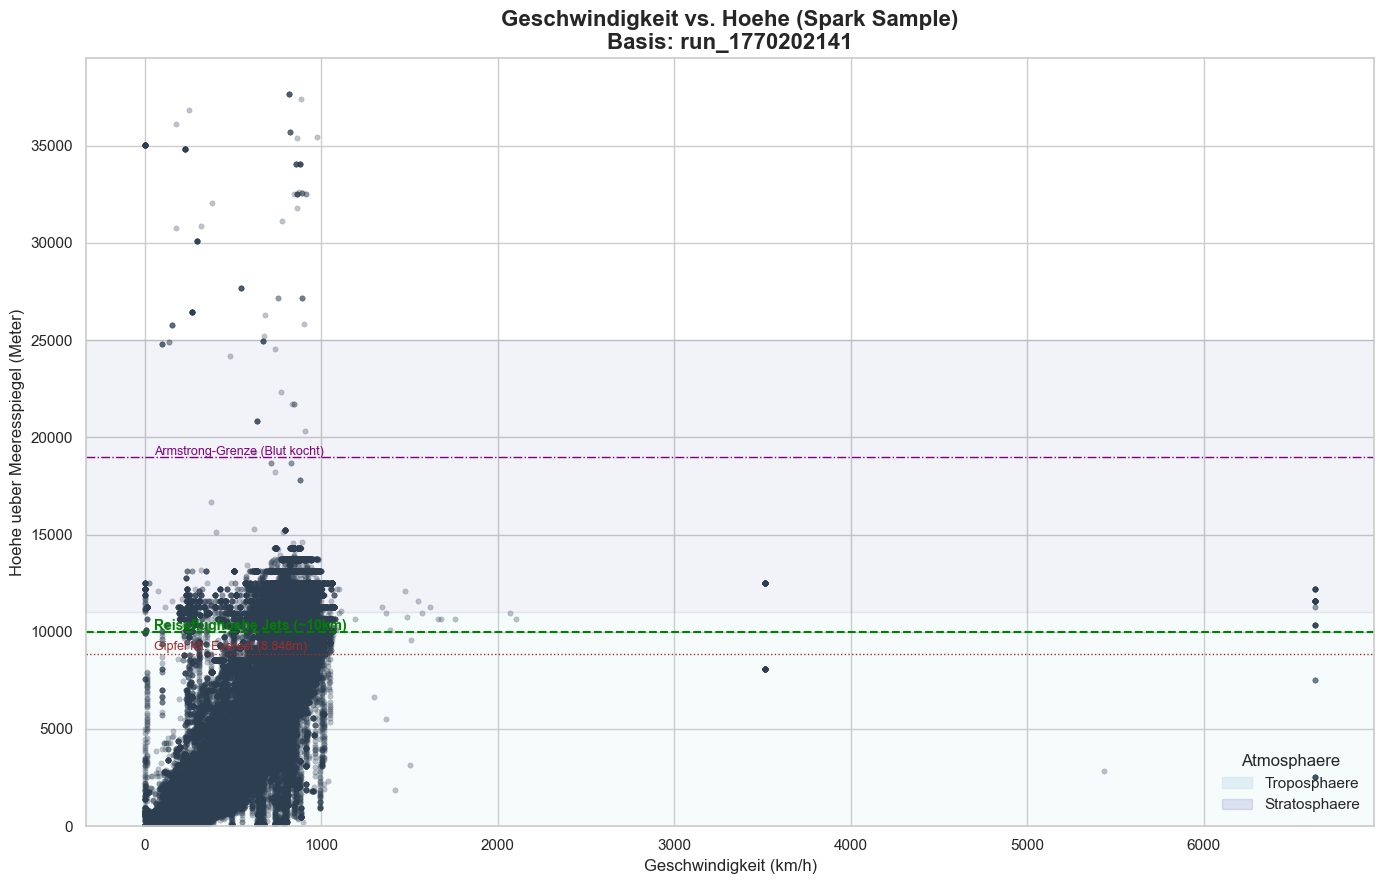

In [9]:
# Design-Settings
sns.set_theme(style="whitegrid")

print("--- Daten Visualisieren ---")

# Spark Session initialisieren
spark = SparkSession.builder \
    .appName("UseCase1_Anomaly") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session aktiv.")

# Wir nutzen die Variable OUTPUT_DIR aus der ersten Zelle.
if 'OUTPUT_DIR' not in locals():
    raise ValueError("Variable OUTPUT_DIR ist nicht definiert. Bitte Zelle 1 ausfuehren!")

print(f"Suche nach Flugdaten in: {OUTPUT_DIR}")

# Run-Ordner finden
possible_patterns = [
    os.path.join(OUTPUT_DIR, "processed", "run_*"),
    os.path.join(OUTPUT_DIR, "run_*")
]

latest_run_path = None
found_folders = []

for pattern in possible_patterns:
    found = glob.glob(pattern)
    if found:
        found_folders.extend(found)

if found_folders:
    # Den neusten Ordner nehmen
    latest_run_path = max(found_folders, key=os.path.getctime)
    print(f"Lade Datensatz via Spark: {latest_run_path}")
else:
    raise FileNotFoundError(f"Keine 'run_*' Ordner in {OUTPUT_DIR} gefunden.")

# Spark DataFrame laden
df_spark = spark.read.parquet(latest_run_path)

# Filterung & Transformation
df_processed = df_spark \
    .withColumn("velocity", col("velocity").cast("double")) \
    .withColumn("baroaltitude", col("baroaltitude").cast("double")) \
    .filter(
    (col("onground") == "False") &
    (col("velocity").isNotNull()) &
    (col("baroaltitude").isNotNull())
) \
    .withColumn("velocity_kmh", col("velocity") * 3.6)

# Sample ziehen und zu Pandas konvertieren
print("Berechne Sample und transferiere zum Client...")

# WICHTIG: lat, lon und icao24 muessen mitgenommen werden fuer Zelle 3
# Wir pruefen sicherheitshalber, welche Spalten existieren
cols_wanted = ["velocity_kmh", "baroaltitude", "lat", "lon", "icao24"]
existing_cols = [c for c in cols_wanted if c in df_processed.columns]

df_sample_pandas = df_processed.select(*existing_cols) \
    .sample(fraction=0.5, seed=42) \
    .limit(200000) \
    .toPandas()

print(f"Daten im RAM (Pandas): {len(df_sample_pandas):,} Punkte bereit fuer Plot.")

# Visualisierung
print("Erstelle Diagramm...")
plt.figure(figsize=(14, 9))

plt.axhspan(0, 11000, color='lightblue', alpha=0.1, label='Troposphaere (Wetter)')
plt.axhspan(11000, 25000, color='darkblue', alpha=0.05, label='Stratosphaere')
sns.scatterplot(
    data=df_sample_pandas,
    x='velocity_kmh', y='baroaltitude',
    color='#2c3e50', alpha=0.3, s=15, edgecolor=None
)

plt.axhline(y=8848, color='brown', linestyle=':', linewidth=1)
plt.text(50, 8900, 'Gipfel Mt. Everest (8.848m)', color='brown', fontsize=9, va='bottom')

plt.axhline(y=10000, color='green', linestyle='--', linewidth=1.5)
plt.text(50, 10100, 'Reiseflughoehe Jets (~10km)', color='green', fontsize=10, fontweight='bold')

max_alt = df_sample_pandas['baroaltitude'].max()
if max_alt > 15000:
    plt.axhline(y=19000, color='purple', linestyle='-.', linewidth=1)
    plt.text(50, 19100, 'Armstrong-Grenze (Blut kocht)', color='purple', fontsize=9)

run_name = os.path.basename(latest_run_path)
plt.title(f"Geschwindigkeit vs. Hoehe (Spark Sample)\nBasis: {run_name}", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Hoehe ueber Meeresspiegel (Meter)")
plt.ylim(0, max(14000, max_alt * 1.05))

tropo_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Troposphaere')
strato_patch = mpatches.Patch(color='darkblue', alpha=0.1, label='Stratosphaere')
plt.legend(handles=[tropo_patch, strato_patch], loc='lower right', title="Atmosphaere")

plt.tight_layout()
plt.show()

### Zelle 3: Lokale Anomalie-Erkennung (Isolation Forest)

Diese Zelle führt eine Anomalie-Erkennung auf dem zuvor via Spark extrahierten Datensample durch. Wir nutzen den **Isolation Forest Algorithmus**, der besonders effizient darin ist, statistische Ausreißer in Daten zu isolieren, ohne dass ein gelabelter Trainingsdatensatz nötig ist. Die identifizierten Anomalien werden anschließend pro Flugzeug (ICAO24) dedupliziert und geografisch auf einer Weltkarte visualisiert, um Hotspots zu erkennen.

---

**Analyse der Skalierbarkeit & Architektur:**

* **Ausführungsumgebung (Client vs. Cluster):** Im Gegensatz zur vorherigen Zelle läuft dieser Berechnungsschritt **lokal auf dem Client (Treiber)** und nutzt die CPU des Notebook-Hosts.
* **RAM-Nadelöhr:** Da der Isolation Forest alle Daten im Arbeitsspeicher benötigt, ist dieser Ansatz **nicht direkt** extrem skalierbar (Gefahr eines *MemoryErrors*).
* **Lösung:** Die Skalierbarkeit wird durch die **hybride Architektur** sichergestellt: Zelle 2 (Spark) übernimmt die Last der Datenreduktion (Filterung & Sampling im Cluster), sodass Zelle 3 (Python) nur noch eine handhabbare, aber statistisch signifikante Menge an Daten verarbeiten muss.
* **Dauer:** Diese Zelle sollte in 5 Sekunden durchlaufen

--- Anomalie Erkennung ---
Übernehme Daten aus Spark-Sample...
Trainiere Isolation Forest Modell...
Gefundene Anomalien (Datenpunkte): 1,999
Eindeutige Flugzeuge mit Anomalien (Plot-Basis): 214
Erstelle Karte aller Anomalien...


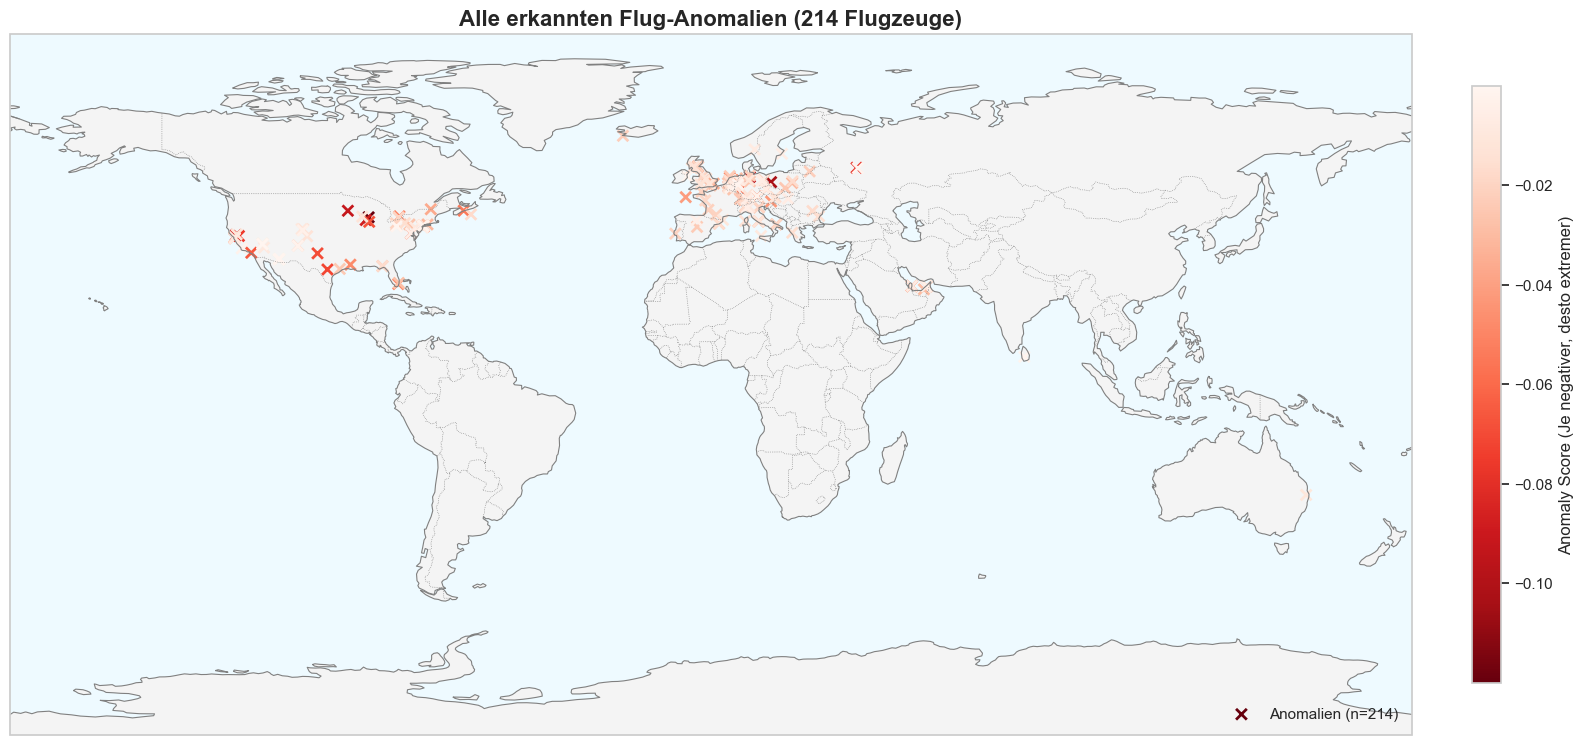

In [10]:
warnings.filterwarnings("ignore", message=".*facecolor will have no effect.*")

print("--- Anomalie Erkennung ---")

# 1. Daten-Handling
if 'df_sample_pandas' in locals():
    print("Übernehme Daten aus Spark-Sample...")
    df_clean = df_sample_pandas.copy()
elif 'df_clean' in locals():
    pass
else:
    raise ValueError("Keine Daten gefunden! Bitte erst Zelle 2 erfolgreich ausführen.")

# 2. Feature Auswahl
print("Trainiere Isolation Forest Modell...")
features = ['velocity_kmh', 'baroaltitude']
X = df_clean[features].fillna(0)

# 3. Modell Training
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(X)

df_clean['anomaly_label'] = model.predict(X)
df_clean['anomaly_score'] = model.decision_function(X)

# 4. Filterung der Anomalien
anomalies = df_clean[df_clean['anomaly_label'] == -1].copy()

cols_geo = ['lat', 'lon']
for col in cols_geo:
    anomalies[col] = pd.to_numeric(anomalies[col], errors='coerce')

# Deduplizierung: Nur der extremste Wert pro Flugzeug (ICAO24)
unique_anomalies = anomalies.sort_values('anomaly_score', ascending=True).drop_duplicates(subset=['icao24'])
print(f"Gefundene Anomalien (Datenpunkte): {len(anomalies):,}")
print(f"Eindeutige Flugzeuge mit Anomalien (Plot-Basis): {len(unique_anomalies):,}")

# Visualisierung der Anomalien
print("Erstelle Karte aller Anomalien...")
plt.figure(figsize=(16, 10))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='#f4f4f4')
ax.add_feature(cfeature.OCEAN, facecolor='#eefaff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, color='gray')

scatter = ax.scatter(
    unique_anomalies['lon'],
    unique_anomalies['lat'],
    c=unique_anomalies['anomaly_score'],
    cmap='Reds_r',
    s=60,
    marker='x',
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label=f'Anomalien (n={len(unique_anomalies)})'
)

ax.set_global()
plt.colorbar(scatter, label='Anomaly Score (Je negativer, desto extremer)', fraction=0.02, pad=0.04)
plt.title(f"Alle erkannten Flug-Anomalien ({len(unique_anomalies)} Flugzeuge)", fontsize=16, fontweight='bold')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Zelle 4: Data Quality Check & Metadaten-Anreicherung

Um die physikalischen Anomalien (aus Zelle 3) in einen operativen Kontext zu setzen, ist eine Verknüpfung mit den Flugzeug-Stammdaten (Hersteller, Modell, Airline) notwendig. Diese Zelle validiert die Qualität dieser Verknüpfung.

**Funktionsweise:**
Es wird ein Abgleich (*Matching*) zwischen den im Datenstrom beobachteten Transponder-Codes (`icao24`) und der statischen OpenSky-Flugzeugdatenbank durchgeführt. Ziel ist es, die **Coverage Rate** zu ermitteln: Für wie viel Prozent der beobachteten Flugzeuge liegen uns Kontextinformationen vor?

**Architektur & Skalierbarkeit:**
* **Aktuelle Umsetzung (Pandas):** Da die Metadaten-Datenbank vergleichsweise klein ist (< 500 MB) und wir nur gegen das extrahierte Sample matchen, ist ein lokaler In-Memory Join mit Pandas hier ausreichend und performant.
* **Big Data Szenario:** Würde man *viele* Flugdaten anreichern wollen, wäre dieser Ansatz ineffizient. In einer Spark-Umgebung würde man hierfür einen **Broadcast Join** verwenden. Dabei wird die kleine Metadaten-Tabelle an alle Cluster-Knoten verteilt, um teure Shuffle-Operationen der riesigen Flugdaten zu vermeiden.
* **Dauer:** Diese Zelle sollte in unter 5 Sekunden durchlaufen

--- Überprüfung der Datenqualität ---
Lade Datenbank: C:\Users\valim\Master\AdvancedDataEngineering\Tester\aircraft_database.parquet
Total Unique Aircraft im Feed: 5,467
Davon in DB identifiziert:     5,299 (96.9%)


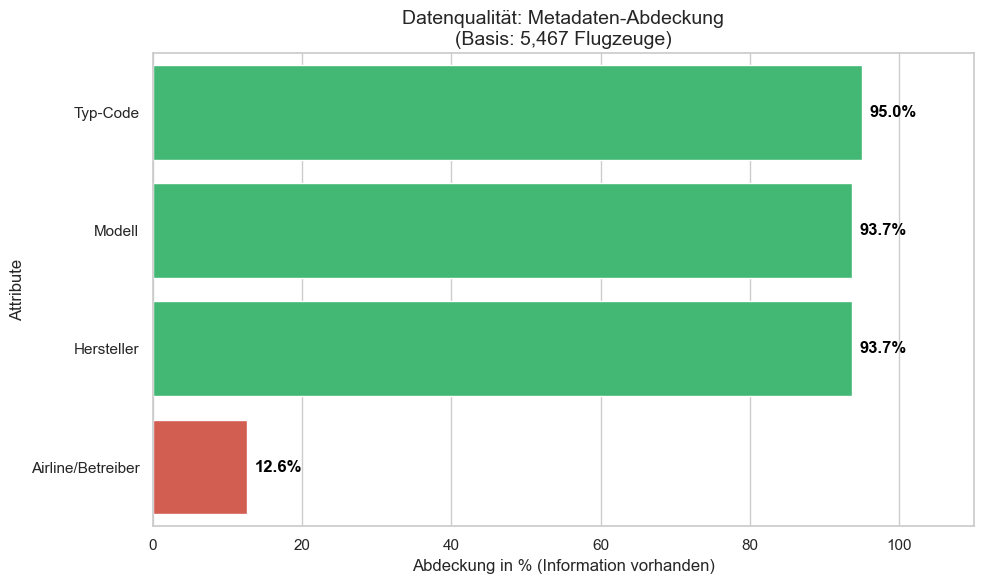

In [11]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

print("--- Überprüfung der Datenqualität ---")

if 'OUTPUT_DIR' in locals():
    DB_PATH = os.path.join(OUTPUT_DIR, "aircraft_database.parquet")
else:
    # Fallback für Tests, falls Zelle 1 übersprungen wurde
    DB_PATH = "data/external/aircraft_database.parquet"
    print(f"Warnung: OUTPUT_DIR nicht gefunden. Versuche Fallback: {DB_PATH}")

if not os.path.exists(DB_PATH):
    raise FileNotFoundError(f"Flugzeug-Datenbank nicht gefunden: {DB_PATH}. Bitte Zelle 1 ausführen!")

print(f"Lade Datenbank: {DB_PATH}")
df_aircraft = pd.read_parquet(DB_PATH)

# Analyse DataFrame bestimmen
if 'df_clean' in locals():
    analysis_df = df_clean
elif 'df_sample_pandas' in locals():
    analysis_df = df_sample_pandas
else:
    raise ValueError("Keine Flugdaten im Speicher gefunden (df_clean oder df_sample_pandas fehlt).")

# Normalisiere icao24 IDs im Feed
feed_ids = analysis_df['icao24'].astype(str).str.lower().str.strip().unique()

if 'icao24' not in df_aircraft.columns:
    df_aircraft = df_aircraft.reset_index()

# Metadaten-IDs ebenfalls normalisieren
df_aircraft['icao24'] = df_aircraft['icao24'].astype(str).str.lower().str.strip()

# matchen der IDs
df_quality = df_aircraft[df_aircraft['icao24'].isin(feed_ids)].copy()

total_flights = len(feed_ids)
matches_count = len(df_quality)
match_rate = (matches_count / total_flights) * 100 if total_flights > 0 else 0

print(f"Total Unique Aircraft im Feed: {total_flights:,}")
print(f"Davon in DB identifiziert:     {matches_count:,} ({match_rate:.1f}%)")

# Qualitätsanalyse der Attribute
attributes = {
    'manufacturername': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ-Code',
    'operator': 'Airline/Betreiber'
}

quality_stats = []
for col, label in attributes.items():
    # Wir suchen die Spalte (case-insensitive)
    actual_col = next((c for c in df_quality.columns if c.lower() == col.lower()), None)

    if actual_col:
        # Zähle Einträge die nicht NaN und nicht leerer String sind
        valid_count = df_quality[actual_col].replace(r'^\s*$', np.nan, regex=True).notna().sum()
        pct = (valid_count / total_flights) * 100 # Basis ist Gesamtanzahl im Feed, nicht nur Matches
        quality_stats.append({'Attribute': label, 'Percentage': pct})
    else:
        quality_stats.append({'Attribute': label, 'Percentage': 0.0})

df_stats = pd.DataFrame(quality_stats).sort_values('Percentage', ascending=False)

# Visualisierung der Datenqualität
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 80 else '#f1c40f' if x > 50 else '#e74c3c' for x in df_stats['Percentage']]
ax = sns.barplot(data=df_stats, x='Percentage', y='Attribute', hue='Attribute', palette=colors, legend=False)

for i, v in enumerate(df_stats['Percentage']):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.title(f"Datenqualität: Metadaten-Abdeckung\n(Basis: {total_flights:,} Flugzeuge)", fontsize=14)
plt.xlabel("Abdeckung in % (Information vorhanden)")
plt.xlim(0, 110)
plt.tight_layout()
plt.show()

### Zelle 5: Detail-Analyse & Risikobewertung (Top 50)

In diesem Schritt werden die rein statistischen Anomalien (aus Zelle 3) operationalisierbar gemacht, indem sie mit physikalischem Kontext angereichert werden.

**Vorgehen:**
1.  **Daten-Fusion:** Durchführung eines *Left Joins* zwischen den identifizierten Anomalien und der lokalen *Aircraft Database* (Parquet), um Hersteller, Modell und Betreiber zuzuordnen.
2.  **Qualitäts-Filter:** Um Fehlalarme durch Datenmüll (z.B. Test-Signale ohne Flugzeug-Zuordnung) zu reduzieren, werden nur **eindeutig identifizierte Flugzeuge** in die Bewertung aufgenommen.
3.  **Ranking:** Das Ergebnis ist eine Risikotabelle der **Top 50 Anomalien**, sortiert nach ihrem *Anomaly Score* (aufsteigend). Dies ermöglicht Analysten, sich auf die signifikantesten Abweichungen zu konzentrieren.

---

**Skalierbarkeits-Betrachtung (Client vs. Cluster):**

* **In-Memory Join (Pandas):** Da die Menge der Anomalien (`unique_anomalies`) durch die vorangegangenen Filterungsschritte massiv reduziert wurde , ist ein lokaler Join im Arbeitsspeicher hier die effizienteste Methode. Die Komplexität ist gering.
* **Big Data Szenario (Broadcast Join):** Würde man stattdessen *alle* Rohdaten mit den Metadaten anreichern wollen, wäre dieser Ansatz unmöglich. In einer Spark-Architektur käme hier ein **Broadcast Join** zum Einsatz: Da die Metadaten-Tabelle (Flugzeugtypen) im Vergleich zu den Bewegungsdaten winzig ist, würde Spark diese Tabelle an alle Cluster-Knoten senden ("broadcasten"), um einen Shuffle-freien, verteilten Join durchzuführen.
* **Dauer:** Diese Zelle sollte in unter 5 Sekunden durchlaufen

In [12]:
print("--- Kontext-Anreicherung ---")

# 1. PRÜFUNG DER VORAUSSETZUNGEN
if 'unique_anomalies' not in locals():
    raise ValueError("Variable 'unique_anomalies' fehlt! Bitte Zelle 3 ausführen.")

# 2. STAMMDATEN LADEN (Robust via OUTPUT_DIR)
# Wir versuchen erst, den DF aus dem Speicher zu nehmen (falls Zelle 4 lief)
if 'df_aircraft' in locals():
    print("Nutze Flugzeug-Datenbank aus Arbeitsspeicher (Zelle 4).")
    aircraft_db = df_aircraft
else:
    # Sonst neu laden
    if 'OUTPUT_DIR' in locals():
        DB_PATH = os.path.join(OUTPUT_DIR, "aircraft_database.parquet")
    else:
        DB_PATH = "data/external/aircraft_database.parquet" # Fallback

    if not os.path.exists(DB_PATH):
        raise FileNotFoundError(f"Datenbank nicht gefunden: {DB_PATH}. Bitte Zelle 1 ausführen!")

    print(f"Lade Datenbank von Festplatte: {DB_PATH}")
    aircraft_db = pd.read_parquet(DB_PATH)

print("Verknüpfe Anomalien mit Stammdaten...")

# 3. JOIN & FILTER
# Left Join: Anomalien links, Metadaten rechts
df_context = pd.merge(unique_anomalies, aircraft_db, on='icao24', how='left')

# Wir behalten nur Zeilen, wo wir Hersteller ODER Modell kennen
df_identified = df_context.dropna(subset=['manufacturerName', 'model'], how='all').copy()

# 4. FINALISIERUNG DER TABELLE
column_mapping = {
    'anomaly_score': 'Risk Score',
    'icao24': 'ICAO ID',
    'manufacturerName': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ',
    'velocity_kmh': 'Speed (km/h)',
    'baroaltitude': 'Höhe (m)',
    'operator': 'Airline' # Falls vorhanden, nehmen wir das auch mit
}

# Nur existierende Spalten auswählen (falls 'operator' in Zelle 1 nicht geladen wurde)
available_cols = [c for c in column_mapping.keys() if c in df_identified.columns]
final_table = df_identified[available_cols].rename(columns=column_mapping)

# Runden für Lesbarkeit
if 'Speed (km/h)' in final_table.columns:
    final_table['Speed (km/h)'] = final_table['Speed (km/h)'].round(1)
if 'Höhe (m)' in final_table.columns:
    final_table['Höhe (m)'] = final_table['Höhe (m)'].round(0).astype(int)
if 'Risk Score' in final_table.columns:
    final_table['Risk Score'] = final_table['Risk Score'].round(4)

# Sortieren: Je negativer (kleiner) der Score, desto extremer die Anomalie
final_table = final_table.sort_values('Risk Score', ascending=True)

# Top 50 extrahieren
top_50 = final_table.head(50)

print(f"Anomalien gesamt: {len(unique_anomalies)}")
print(f"Davon identifiziert (mit Metadaten): {len(df_identified)}")
print("Anzeige der Top 50 Risiko-Fälle:")

# Schöne Darstellung im Notebook
display(top_50.set_index('Risk Score'))

--- Kontext-Anreicherung ---
Nutze Flugzeug-Datenbank aus Arbeitsspeicher (Zelle 4).
Verknüpfe Anomalien mit Stammdaten...
Anomalien gesamt: 214
Davon identifiziert (mit Metadaten): 177
Anzeige der Top 50 Risiko-Fälle:


,ICAO ID,Hersteller,Modell,Typ,Speed (km/h),Höhe (m),Airline
Risk Score,,,,,,,
-0.0953,3d14df,Grumman American,Grumman American AA-5B Tiger,AA5,178.8,36088,None
-0.0883,a095ef,Gippsaero Pty Ltd,GA8 TC-320,GA8,175.7,30785,None
-0.0873,a37fa0,Piper,PA-28-151,P28A,228.1,34808,None
-0.0848,44cdc4,Airbus,A320 214,A320,250.2,36820,Brussels Airlines
-0.0779,4249cb,Boeing,737 524/W,B735,294.8,30114,None
-0.0720,a196f3,Embraer S A,ERJ 170-200 LR,E75L,315.4,30876,None
-0.0717,a9ac81,Cessna,T210N,T210,22.3,12497,None
-0.0694,a170a8,Piaggio,P180,P180,381.5,32065,None
-0.0671,a22bf0,Boeing,737-7H4,B737,0.0,12055,None


# Use Case 2 : Flugphasen-Analyse

In diesem Schritt erweitern wir die Betrachtung von *Flughöhe* und *Geschwindigkeit* um eine entscheidende dritte Dimension: die **Steigrate (`vertrate`)**.

Im vorherigen Use Case blieb oft unklar, ob ein Flugzeug auf mittlerer Höhe gerade stabil fliegt oder sich in einer dynamischen Phase befindet. Durch die Hinzunahme der Steigrate können wir das Flugverhalten nun präzise segmentieren.

**Vorteile der Vertical-Rate-Analyse:**
* **Klare Phasentrennung:** Wir können zwischen **Start** (positive Steigrate), **Landung** (negative Steigrate) und **Reiseflug** (Steigrate ≈ 0) unterscheiden.
* **Ground Traffic Detection:** Ein Flugzeug am Boden zeichnet sich nicht nur durch niedrige Höhe, sondern zwingend durch eine Steigrate von **0** aus. Dies filtert Fehlmessungen effektiv.
* **Verhaltensmuster:** Anomalien (z.B. schnelles Sinken in großer Höhe) werden sofort sichtbar.

### Zelle 6: Multi-Dimensionale Analyse

In diesem Schritt erweitern wir die Betrachtung um eine dritte Dimension: die **Steigrate (`vertrate`)**.
Dies ermöglicht eine präzise Segmentierung der Flugphasen, die allein durch Höhe und Geschwindigkeit nicht möglich wäre:
* **Steigflug (Climb):** Positive Steigrate (Rot).
* **Sinkflug (Descent):** Negative Steigrate (Blau).
* **Reiseflug (Cruise):** Steigrate nahe 0 (Grau/Weiß).

**Skalierbarkeits-Architektur:**
Um auch bei Datensätzen im Terabyte-Bereich performant zu bleiben, verlagern wir die Berechnungslogik in den **Spark-Cluster**:
1.  **Distributed Casting & Calculation:** Die Umrechnung von `m/s` in `km/h` erfolgt parallelisiert auf den Workern.
2.  **Server-Side Filtering:** Der Filter `between(-90, 90)` wird angewendet, *bevor* Daten bewegt werden. Dies eliminiert extremes Rauschen (Messfehler) und reduziert die Datenmenge frühzeitig.
3.  **Visualisierung:** Das Notebook empfängt lediglich das bereinigte Sample ("Smart Data") zur grafischen Darstellung.

--- Flugphasen Analyse ---
Suche Daten in: C:\Users\valim\Master\AdvancedDataEngineering\Tester
Datenquelle: run_1770202141
Nutze Höhen-Spalte: geoaltitude
Ziehe Sample für Visualisierung...
Daten geladen: 200,000 Punkte.


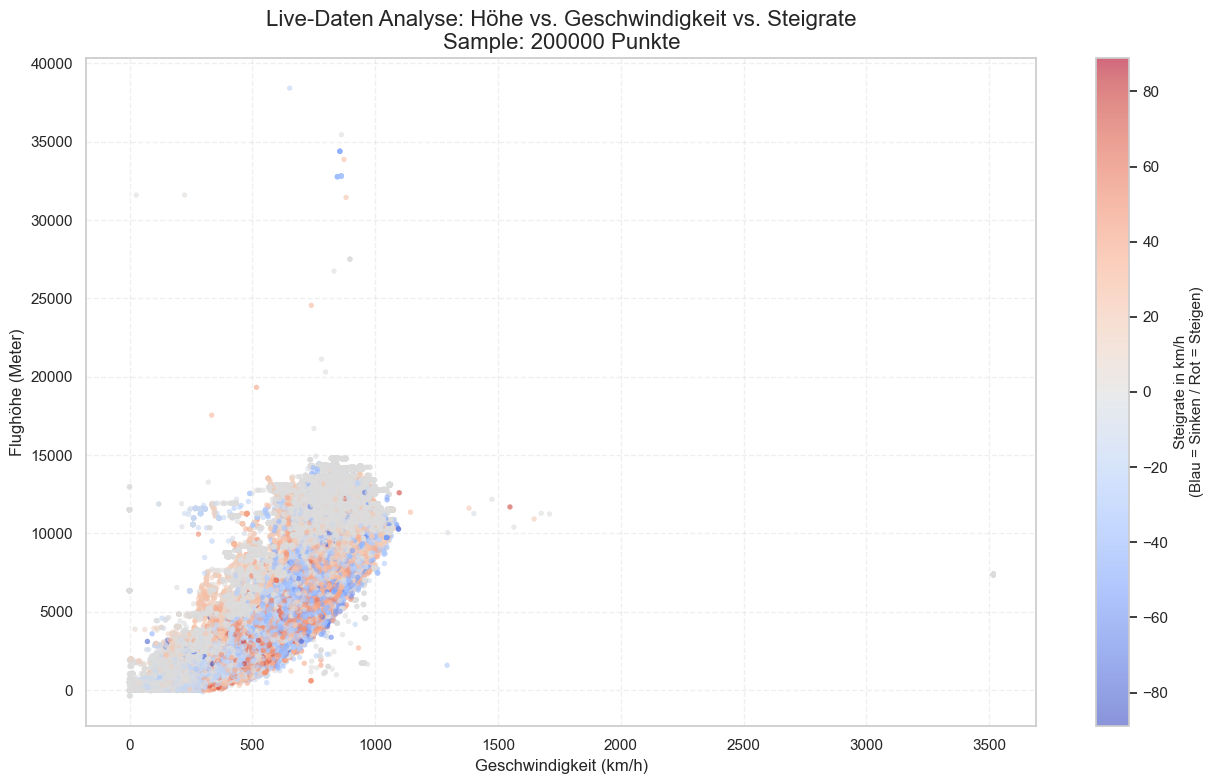

In [13]:
from pyspark.sql.functions import col

print("--- Flugphasen Analyse ---")

# Setup & Pfad-Findung
spark = SparkSession.builder.appName("UseCase2_Vertical").getOrCreate()

if 'OUTPUT_DIR' not in locals():
    raise ValueError("Variable OUTPUT_DIR fehlt. Bitte Zelle 1 ausführen.")

print(f"Suche Daten in: {OUTPUT_DIR}")

# Pfadlogik wie in Zelle 2
possible_patterns = [
    os.path.join(OUTPUT_DIR, "processed", "run_*"),
    os.path.join(OUTPUT_DIR, "run_*")
]

latest_run_path = None
found_folders = []
for pattern in possible_patterns:
    found = glob.glob(pattern)
    if found:
        found_folders.extend(found)

if found_folders:
    latest_run_path = max(found_folders, key=os.path.getctime)
    print(f"Datenquelle: {os.path.basename(latest_run_path)}")
else:
    raise FileNotFoundError("Keine Daten gefunden.")

# Spark DataFrame laden
df_spark = spark.read.parquet(latest_run_path)

# Wir benötigen: velocity, geoaltitude (oder baroaltitude), vertrate
cols_raw = df_spark.columns
alt_col = 'geoaltitude' if 'geoaltitude' in cols_raw else 'baroaltitude'

print(f"Nutze Höhen-Spalte: {alt_col}")

# Casting & Berechnung im Cluster
df_3d = df_spark \
    .withColumn("velocity", col("velocity").cast("double")) \
    .withColumn(alt_col, col(alt_col).cast("double")) \
    .withColumn("vertrate", col("vertrate").cast("double")) \
    .withColumn("velocity_kmh", col("velocity") * 3.6) \
    .withColumn("vertrate_kmh", col("vertrate") * 3.6) # Steigrate in km/h umrechnen

# Filterung ungültiger Werte
df_filtered = df_3d.filter(
    col("velocity").isNotNull() &
    col(alt_col).isNotNull() &
    col("vertrate").isNotNull() &
    col("vertrate_kmh").between(-90, 90)
)

print("Ziehe Sample für Visualisierung...")

df_plot_data = df_filtered.select("velocity_kmh", alt_col, "vertrate_kmh") \
    .sample(fraction=0.5, seed=42) \
    .limit(200000) \
    .toPandas()

print(f"Daten geladen: {len(df_plot_data):,} Punkte.")

# Visualisierung
if not df_plot_data.empty:
    plt.figure(figsize=(13, 8))

    # Scatterplot mit 3. Dimension als Farbe
    scatter = plt.scatter(
        df_plot_data['velocity_kmh'],
        df_plot_data[alt_col],
        c=df_plot_data['vertrate_kmh'],
        cmap='coolwarm', # Blau = Sinken, Rot = Steigen
        s=15,
        alpha=0.6,
        edgecolor='none'
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label('Steigrate in km/h\n(Blau = Sinken / Rot = Steigen)', fontsize=11)

    plt.title(f'Live-Daten Analyse: Höhe vs. Geschwindigkeit vs. Steigrate\nSample: {len(df_plot_data)} Punkte', fontsize=16)
    plt.xlabel('Geschwindigkeit (km/h)', fontsize=12)
    plt.ylabel('Flughöhe (Meter)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Warnung: Leeres DataFrame nach Filterung.")

### Zelle 7: Globale Flughafen-Erkennung

Dieser Use Case demonstriert, wie man kritische Infrastruktur (Flughäfen) allein aus den Bewegungsdaten ableiten kann, ohne externe Kartenquellen zu nutzen.

**Die algorithmische Herausforderung:**
Ein einfaches Zählen von GPS-Punkten würde zu verzerrten Ergebnissen führen. Ein einzelnes Flugzeug, das zwei Stunden am Gate steht, sendet Tausende Signale und würde fälschlicherweise als "großer Flughafen" erscheinen, während eine stark frequentierte Landebahn mit rollendem Verkehr statistisch untergeht.

**Lösungsschritte:**
1.  **Distributed Ground Detection (Spark):** Identifikation von Flugzeugen am Boden durch physikalische Parameter (Höhe < 500m, Speed < 50 km/h) und Status-Flags.
2.  **Anti-Bias Logik:** Mittels `dropDuplicates` wird sichergestellt, dass jedes Flugzeug (ICAO24) nur **genau eine Stimme** für seinen Standort abgibt. Egal ob es 5 Minuten oder 5 Stunden dort steht – es zählt als ein Flugzeug.
3.  **Spatial Non-Maximum Suppression:** Ein iterativer Algorithmus bereinigt das Ergebnis räumlich. Wenn mehrere erkannte Standorte dicht beieinander liegen (z.B. Terminal 1 und Terminal 2 desselben Flughafens), wird nur der stärkste Standort behalten und die schwächeren Nachbarn unterdrückt. Dies verhindert Doppelzählungen desselben Flughafens.

**Architektur & Skalierbarkeit (Hybrid-Ansatz):**
Dieser Schritt folgt einem klassischen **Big-Data-Pattern**:
* **Cluster (Spark):** Die speicherintensiven Aufgaben laufen verteilt auf den Worker-Nodes. Hier wird die Datenmenge von Milliarden Zeilen auf wenige Tausend potenzielle Koordinaten reduziert.
* **Lokal (Client/Pandas):** Da die aggregierte Kandidaten-Liste sehr klein ist, wird sie in den Arbeitsspeicher des Clients geladen. Die mathematisch komplexe Distanzberechnung erfolgt dann effizient via Numpy auf der CPU des Nutzers.

--- Flughafen Detection ---
Suche Daten in: C:\Users\valim\Master\AdvancedDataEngineering\Tester
Datenquelle: run_1770202141
Starte verteilte Aggregation im Cluster...
Hole Liste der potenziellen Flughäfen...
Aggregation fertig. 8550 potenzielle Standorte gefunden.
Starte räumliche Bereinigung (Zusammenfassen naher Standorte)...
Final identifiziert: 50 mögliche Flughäfen.


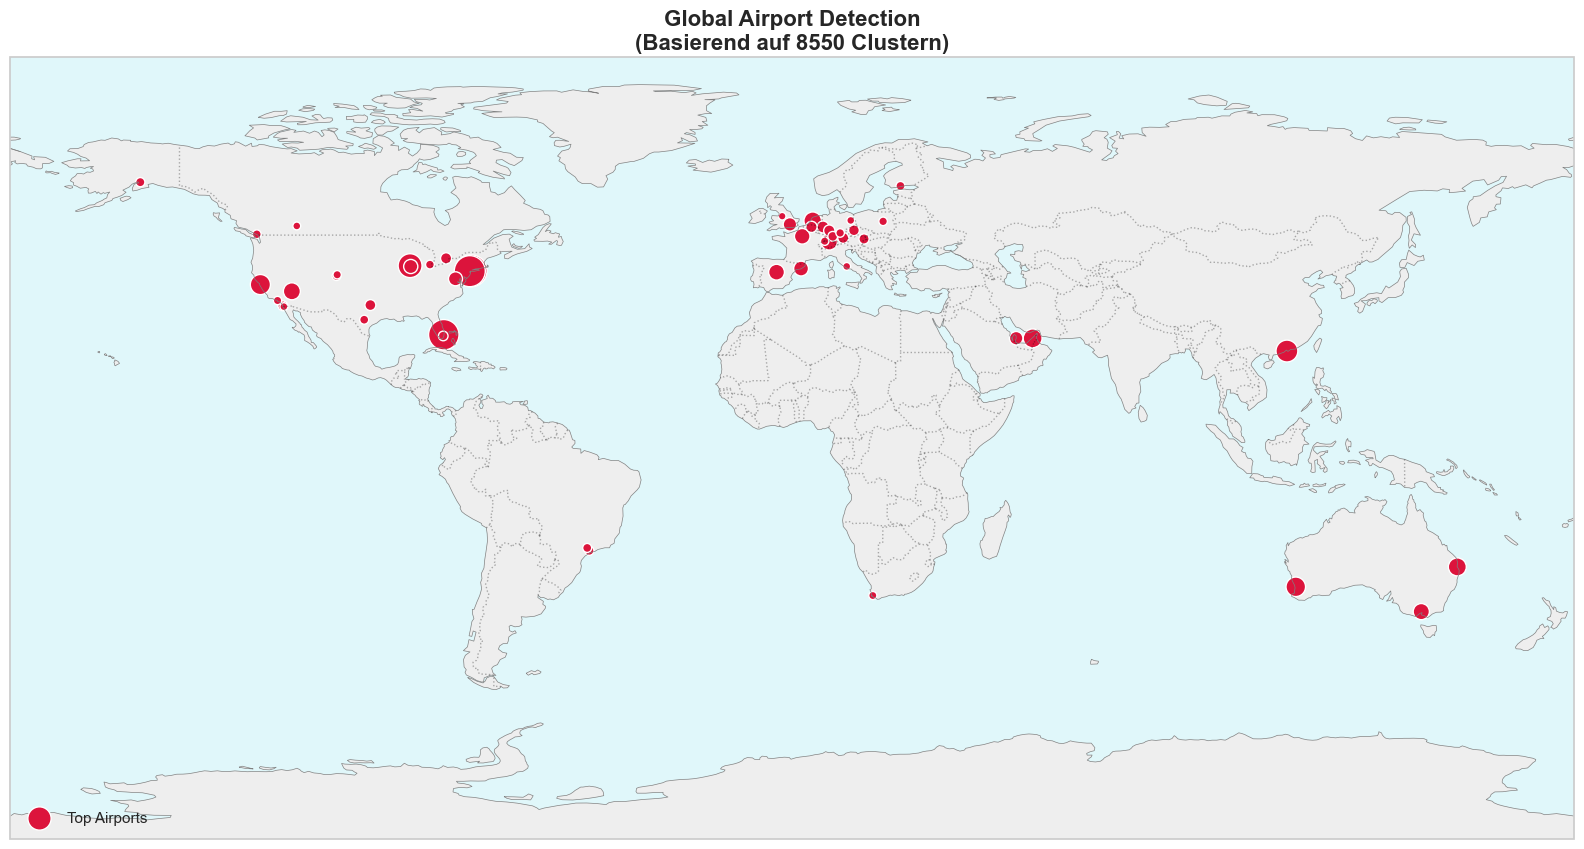

In [14]:
import os
import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyspark.sql import SparkSession

# WICHTIG: Der "sichere" Import.
# Wir nutzen 'F.count' statt 'count', damit deine Variablen keine Konflikte mehr verursachen.
from pyspark.sql import functions as F

# Warnungen unterdrücken
warnings.filterwarnings('ignore')

print("--- Flughafen Detection ---")

# Setup
if 'spark' not in locals():
    spark = SparkSession.builder.appName("UseCase3_Hubs").getOrCreate()

# Falls OUTPUT_DIR nicht definiert ist, versuchen wir es aus der Config zu holen oder werfen einen Fehler
if 'OUTPUT_DIR' not in locals():
    # Versuch eines Fallbacks, falls Zelle 1 nicht lief (bitte Pfad anpassen falls nötig)
    raise ValueError("Variable 'OUTPUT_DIR' fehlt! Bitte führe Zelle 1 (Config) aus.")

print(f"Suche Daten in: {OUTPUT_DIR}")

# Pfadlogik
possible_patterns = [
    os.path.join(OUTPUT_DIR, "processed", "run_*"),
    os.path.join(OUTPUT_DIR, "run_*")
]

found_folders = []
for pattern in possible_patterns:
    found = glob.glob(pattern)
    if found:
        found_folders.extend(found)

if not found_folders:
    raise FileNotFoundError(f"Keine Daten in {OUTPUT_DIR} gefunden.")

latest_run_path = max(found_folders, key=os.path.getctime)
print(f"Datenquelle: {os.path.basename(latest_run_path)}")

# Verteilte Aggregation
print("Starte verteilte Aggregation im Cluster...")
df_spark = spark.read.parquet(latest_run_path)

# Casting mit F.col(...)
df_cast = df_spark \
    .withColumn("lat", F.col("lat").cast("double")) \
    .withColumn("lon", F.col("lon").cast("double")) \
    .withColumn("velocity", F.col("velocity").cast("double")) \
    .withColumn("geoaltitude", F.col("geoaltitude").cast("double")) \
    .withColumn("vertrate", F.col("vertrate").cast("double"))

# A) Filter: Nur Boden-nahe Flugzeuge
df_ground = df_cast.filter(
    (F.col("lat").isNotNull()) & (F.col("lon").isNotNull()) &
    (
            (F.col("onground") == "True") |
            (
                    (F.col("geoaltitude") < 500) &
                    (F.col("velocity") * 3.6 < 50) &
                    (F.col("vertrate").between(-0.5, 0.5))
            )
    )
)

# B) Deduplizierung
df_unique_planes = df_ground.dropDuplicates(["icao24"])

# C) Standort-Bestimmung (Runden)
df_loc_rounded = df_unique_planes \
    .withColumn("lat_cluster", F.round(F.col("lat"), 2)) \
    .withColumn("lon_cluster", F.round(F.col("lon"), 2))

# D) Zählen (Hier war der Fehler!)
# Wir nutzen jetzt explizit F.count("*") -> Das funktioniert immer.
df_candidates = df_loc_rounded.groupBy("lat_cluster", "lon_cluster") \
    .agg(F.count("*").alias("flight_count")) \
    .orderBy(F.desc("flight_count"))

# Transfer zum Client
print("Hole Liste der potenziellen Flughäfen...")
candidates = df_candidates.toPandas()

print(f"Aggregation fertig. {len(candidates)} potenzielle Standorte gefunden.")
print("Starte räumliche Bereinigung (Zusammenfassen naher Standorte)...")

# Räumliche Entkernung (Clustering)
if not candidates.empty:
    lats = candidates['lat_cluster'].values
    lons = candidates['lon_cluster'].values
    active = np.ones(len(candidates), dtype=bool)

    # Threshold (ca. 20km)
    THRESHOLD_DEG = 0.2
    THRESHOLD_SQ = THRESHOLD_DEG ** 2

    for i in range(len(candidates)):
        if not active[i]: continue

        # Vektorisierte Distanz
        lat_diff = lats[i+1:] - lats[i]
        # Einfache Kosinus-Korrektur für Längengrad
        lon_diff = (lons[i+1:] - lons[i]) * np.cos(np.radians(lats[i]))
        dist_sq = lat_diff**2 + lon_diff**2

        # Zu nahe Nachbarn finden
        too_close = np.where(dist_sq < THRESHOLD_SQ)[0]

        # Nachbarn deaktivieren
        active[i + 1 + too_close] = False

    # Top 50 auswählen
    top_hubs = candidates[active].head(50)
    print(f"Final identifiziert: {len(top_hubs)} mögliche Flughäfen.")

    # --- VISUALISIERUNG ---
    plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor='#eeeeee')
    ax.add_feature(cfeature.OCEAN, facecolor='#e0f7fa')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.3)

    scatter = ax.scatter(
        top_hubs['lon_cluster'],
        top_hubs['lat_cluster'],
        s=top_hubs['flight_count'] * 2,
        c='crimson',
        marker='o',
        edgecolor='white',
        linewidth=1,
        transform=ccrs.PlateCarree(),
        label='Top Airports'
    )

    ax.set_global()
    plt.title(f"Global Airport Detection\n(Basierend auf {len(candidates)} Clustern)", fontsize=16, fontweight='bold')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

else:
    print("Keine potenziellen Flughäfen gefunden.")

# Skalierbarkeitsanalyse & Performance-Benchmarks

Nachdem die funktionale Logik der Pipeline implementiert wurde, widmen wir uns nun den **nicht-funktionalen Anforderungen**. In diesem Kapitel validieren wir empirisch, ob die gewählte **hybride Architektur** (Distributed Computing + Local Inference) auch unter extremen Lastbedingungen stabil und effizient arbeitet.

Da reale "Big Data"-Volumina auf einer lokalen Entwicklungsumgebung schwer zu replizieren sind, nutzen wir für die Stresstests das Verfahren des **Synthetic Upscaling**: Wir vervielfachen die vorhandenen Daten künstlich im Arbeitsspeicher, um Terabyte-Scale-Szenarien und massive Traffic-Surges zu simulieren.

**Die Test-Strategie umfasst drei gezielte Experimente:**

1.  **Experiment 1: Infrastructure Scalability & Resilience (Zelle 8)**
    * *Fokus:* **Data Engineering & System-Stabilität (Spark)**.
    * *Ziel:* Validierung der Performance und Robustheit in drei Dimensionen:
        1. **CPU-Effizienz:** Wie gut werden zusätzliche Kerne genutzt (Speedup)?
        2. **Volumen-Skalierung:** Wächst die Laufzeit linear zur Datenmenge ($O(n)$)?
        3. **Crash-Resistenz:** Beweis des **"Disk Spill"**-Mechanismus – kann das System bei akutem RAM-Mangel stabil weiterarbeiten, indem es Daten auf die Festplatte auslagert, statt abzustürzen?

2.  **Experiment 2: AI Inference Throughput (Zelle 9)**
    * *Fokus:* **Data Science (Client/Speed)**.
    * *Ziel:* Messung der reinen Vorhersage-Geschwindigkeit. Wir untersuchen, ob das System "Economies of Scale" zeigt und wie viele Tausend Flugzeuge pro Sekunde in Echtzeit bewertet werden können.

3.  **Experiment 3: Resource Efficiency (Zelle 10)**
    * *Fokus:* **System-Stabilität (Client/RAM)**.
    * *Ziel:* Analyse der "Space Complexity". Wir wollen beweisen, dass der Speicherbedarf nicht exponentiell explodiert, um "Out-of-Memory"-Abstürze bei großen Datenmengen auszuschließen.

---

### Zelle 8: Experiment 1: Performance & Skalierbarkeits-Benchmark (Spark)

Um die Eignung der Architektur für Big Data Szenarien zu validieren, führen wir systematisches Benchmarking durch. Wir nutzen die rechenintensive Logik der "Airport Detection" (Shuffle-Operation durch `dropDuplicates`), um das Verhalten des Systems unter Last zu messen. Diese Zelle läuft in 2-3 Minuten durch. (Spark, Cluster Simulation)

**Getestete Szenarien:**
1.  **Ressourcen-Skalierung (Vertical Scaling):** Wie verhält sich die Laufzeit bei Erhöhung der CPU-Kerne (z.B. 1 vs. 2 vs. 4 Kerne)? Dies prüft die Parallelisierungs-Effizienz von Spark.
2.  **Daten-Skalierung (Volume Scaling):** Wie steigt der Zeitbedarf bei Vervielfachung der Datenmenge (1x, 2x, 4x)? 
3.  **Resilience & Disk Spill (Speicher-Stabilität):** Wir verarbeiten eine große Datenmenge einmal mit ausreichend RAM ("In-Memory") und einmal unter starkem Speichermangel ("Low RAM"). Wir wollen beweisen, dass das System bei RAM-Mangel nicht abstürzt (*Out Of Memory*), sondern die Last physikalisch auf die Festplatte auslagert ("Spill"). Dies wird durch die Messung der kumulierten Schreibzugriffe (Disk Writes) sichtbar gemacht.

*Hinweis: Da wir auf einem lokalen System testen, werden die Daten für den Volumentest künstlich dupliziert (`union`), um Big Data Verhalten zu simulieren.*


In [ ]:
import time
import threading
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import glob
import os

print("--- Spark: Performance Benchmark CPU, DATA und RAM ---")

# Setup & Pfad-Findung
if 'OUTPUT_DIR' not in locals():
    raise ValueError("OUTPUT_DIR fehlt (Zelle 1 nicht ausgeführt).")

print(f"Suche Daten in: {OUTPUT_DIR}")

possible_patterns = [os.path.join(OUTPUT_DIR, "processed", "run_*"), os.path.join(OUTPUT_DIR, "run_*")]
latest_run_path = None
for pattern in possible_patterns:
    found = glob.glob(pattern)
    if found: latest_run_path = max(found + (([latest_run_path] if latest_run_path else [])), key=os.path.getctime)

if not latest_run_path: raise FileNotFoundError("Keine Daten gefunden.")

print(f"Datenquelle: {os.path.basename(latest_run_path)}")

# Disk Monitor Klasse
class DiskMonitor:
    def __init__(self, interval=0.2):
        self.interval = interval
        self.running = False
        self.data = []
        self.thread = None
        self.start_bytes = 0

    def start(self):
        self.running = True
        self.data = []
        self.start_bytes = psutil.disk_io_counters().write_bytes
        self.thread = threading.Thread(target=self._monitor)
        self.thread.start()

    def stop(self):
        self.running = False
        if self.thread: self.thread.join()
        return pd.DataFrame(self.data, columns=["timestamp", "total_mb"])

    def _monitor(self):
        start_time = time.time()
        while self.running:
            time.sleep(self.interval)
            current_bytes = psutil.disk_io_counters().write_bytes
            written_mb = (current_bytes - self.start_bytes) / (1024 * 1024)
            self.data.append([time.time() - start_time, written_mb])

# CPU und Daten Volumen Benchmark
print("\n--- TEIL A: CPU & VOLUMEN SKALIERUNG ---")

scenarios_perf = [
    # Vertical Scaling
    {"name": "1. Baseline (1 Core)",    "cores": 1, "mem": "2g", "data_mult": 10, "type": "resource"},
    {"name": "2. Multi-Core (2 Cores)", "cores": 2, "mem": "2g", "data_mult": 10, "type": "resource"},
    {"name": "3. Multi-Core (4 Cores)", "cores": 4, "mem": "4g", "data_mult": 10, "type": "resource"},
    # Data Scaling
    {"name": "4. Data x20 (4 Cores)",    "cores": 4, "mem": "4g", "data_mult": 20, "type": "data"},
    {"name": "5. Data x40 (4 Cores)",    "cores": 4, "mem": "4g", "data_mult": 40, "type": "data"}
]

results_perf = []

for i, sc in enumerate(scenarios_perf):
    print(f"Starte Szenario A.{i+1}: {sc['name']} ...")

    try:
        SparkSession.builder.getOrCreate().stop()
        time.sleep(1)
    except: pass

    spark = SparkSession.builder \
        .appName(f"BenchA_{sc['name']}") \
        .master(f"local[{sc['cores']}]") \
        .config("spark.driver.memory", sc['mem']) \
        .getOrCreate()

    # Daten laden
    df = spark.read.parquet(latest_run_path)
    if sc['data_mult'] > 1:
        original_df = df
        for _ in range(sc['data_mult'] - 1):
            df = df.union(original_df)

    # Workload: Shuffle (CPU intensiv)
    start_time = time.time()
    df.filter(col("onground") == "True").dropDuplicates(["icao24"]).groupBy("lat", "lon").count().count()
    duration = time.time() - start_time

    print(f" -> Fertig in {duration:.2f} s")

    results_perf.append(sc | {"Dauer (s)": duration})

# RAM Limit & Disk Spill Benchmark
print("\n--- TEIL B: RAM LIMIT & DISK SPILL ---")

SPILL_MULT = 20 # Datenmenge für den Spill Test

scenarios_spill = [
    {"name": "In-Memory (High RAM)", "mem": "4g",   "fraction": "0.6", "color": "green"},
    {"name": "Disk Spill (Low RAM)", "mem": "512m", "fraction": "0.1", "color": "red"}
]

disk_logs = {}

for sc in scenarios_spill:
    print(f"Starte Szenario B: {sc['name']} ...")

    try:
        SparkSession.builder.getOrCreate().stop()
        time.sleep(2)
    except: pass

    spark = SparkSession.builder \
        .appName(f"BenchB_{sc['name']}") \
        .master("local[4]") \
        .config("spark.driver.memory", sc['mem']) \
        .config("spark.executor.memory", sc['mem']) \
        .config("spark.memory.fraction", sc['fraction']) \
        .getOrCreate()

    # Daten laden & Vervielfachen
    df = spark.read.parquet(latest_run_path)
    big_df = df
    for _ in range(SPILL_MULT - 1):
        big_df = big_df.union(df)

    print(f" -> Daten ({SPILL_MULT}x) bereit. Monitor startet...")

    monitor = DiskMonitor()
    monitor.start()

    # Workload: Sortieren (RAM/Disk intensiv)
    try:
        big_df.sortWithinPartitions("velocity").write.format("noop").mode("overwrite").save()
    except Exception as e:
        print(f"Fehler: {e}")

    log_df = monitor.stop()
    disk_logs[sc['name']] = log_df
    print(f" -> Geschrieben: {log_df['total_mb'].max() if not log_df.empty else 0:.1f} MB")

# Visualisierung der Ergebnisse
df_perf = pd.DataFrame(results_perf)

plt.figure(figsize=(18, 6))

# Plot 1: Ressourcen (CPU)
plt.subplot(1, 3, 1)
df_cpu = df_perf[df_perf['type'] == 'resource']
sns.barplot(data=df_cpu, x='cores', y='Dauer (s)', palette='viridis')
plt.title("1. Ressourcen-Skalierung (CPU)", fontweight='bold')
plt.xlabel("Anzahl CPU Kerne")
plt.ylabel("Dauer (s)")
plt.grid(axis='y', alpha=0.3)

# Plot 2: Daten Volumen
plt.subplot(1, 3, 2)
df_data = df_perf[df_perf['cores'] == 4]
sns.lineplot(data=df_data, x='data_mult', y='Dauer (s)', marker='o', color='crimson', linewidth=2)
plt.title("2. Volumen-Skalierung (Daten)", fontweight='bold')
plt.xlabel("Daten-Menge (x-fach)")
plt.ylabel("Dauer (s)")
plt.grid(True, alpha=0.3)
plt.xticks(sorted(df_data['data_mult'].unique()))

# Plot 3: Disk Spill
plt.subplot(1, 3, 3)
for sc in scenarios_spill:
    name = sc['name']
    if name in disk_logs and not disk_logs[name].empty:
        df_log = disk_logs[name]
        sns.lineplot(x=df_log['timestamp'], y=df_log['total_mb'],
                     label=name, color=sc['color'], linewidth=3)
        # Fill area for Spill
        if "Spill" in name:
            plt.fill_between(df_log['timestamp'], df_log['total_mb'], color='red', alpha=0.1)

plt.title(f"3. RAM Limit & Disk Spill ({SPILL_MULT}x Daten)", fontweight='bold')
plt.xlabel("Laufzeit (s)")
plt.ylabel("Kumulierte Disk Writes (MB)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

--- Spark: Performance Benchmark CPU, DATA und RAM ---
Suche Daten in: C:\Users\valim\Master\AdvancedDataEngineering\Tester
Datenquelle: run_1770202141

--- TEIL A: CPU & VOLUMEN SKALIERUNG ---
Starte Szenario A.1: 1. Baseline (1 Core) ...
 -> Fertig in 90.72 s
Starte Szenario A.2: 2. Multi-Core (2 Cores) ...
 -> Fertig in 46.02 s
Starte Szenario A.3: 3. Multi-Core (4 Cores) ...
 -> Fertig in 23.85 s
Starte Szenario A.4: 4. Data x20 (4 Cores) ...


### Zelle 9: Experiment 2 - AI Inference Scalability (Durchsatz)

Nachdem wir in Zelle 8 die Skalierbarkeit der *Datenvorverarbeitung* (Spark Cluster) bewiesen haben, untersuchen wir nun die Leistungsfähigkeit des *lokalen AI-Modells* auf dem Client (Lokal mit Python und Pandas). Diese Zelle läuft in etwa 1-2 Minuten durch.

**Unterschied zum vorherigen Experiment:**
Während Zelle 8 I/O- und Shuffle-lastig war (Daten bewegen), ist dieses Experiment **CPU-bound** (reines Rechnen). Wir messen die **Inference Speed**: Wie viele Flugzeuge kann das trainierte `IsolationForest`-Modell pro Sekunde bewerten?

**Szenario:**
Wir simulieren eine massive Zunahme des Flugverkehrs ("Traffic Surge"). Da unser Trainingsdatensatz begrenzt ist, nutzen wir **Synthetic Upscaling**: Wir vervielfachen die Daten im Arbeitsspeicher (bis zum Doppelten), um zu prüfen, ob der Durchsatz linear mit der Menge steigt oder ob Overheads die Verarbeitung bei großen Batches ausbremsen.

In [ ]:
print("--- Test der Durchsatzrate ---")

# Datenquelle bestimmen
if 'df_clean' in locals():
    data_source = df_clean
elif 'df_sample_pandas' in locals():
    data_source = df_sample_pandas
else:
    raise ValueError("Keine Daten gefunden. Bitte Zelle 2 oder 3 ausführen.")

print(f"Basis-Datensatz: {len(data_source):,} Zeilen.")

# Modell Initialisierung
print("Initialisiere AI-Modell (Isolation Forest)...")
features = ['velocity_kmh', 'baroaltitude']

train_sample = data_source.sample(n=min(100000, len(data_source)), random_state=42)

# n_jobs=-1 nutzt alle CPU-Kerne für die Vorhersage
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
model.fit(train_sample[features].fillna(0))

print("Modell bereit. Starte Durchsatz-Test...")

# Messungen bei verschiedenen Lastfaktoren
factors = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
results = []

for f in factors:
    # Daten generieren
    if f <= 1.0:
        # Einfaches Sampling
        df_work = data_source.sample(frac=f, random_state=42)
    else:
        # Daten vervielfachen für Stress-Test (> 100%)
        full_copies = int(f)
        remainder = f - full_copies

        parts = [data_source] * full_copies
        if remainder > 0.001:
            parts.append(data_source.sample(frac=remainder, random_state=42))

        df_work = pd.concat(parts, ignore_index=True)

    n_rows = len(df_work)

    # Input Features vorbereiten (Null-Handling wie im Training)
    X_test = df_work[features].fillna(0)

    # Messung starten
    start_time = time.time()

    # Die kritische Zeile: AI trifft Entscheidungen
    _ = model.predict(X_test)

    end_time = time.time()

    # metrics berechnen
    if f > 1.0:
        del df_work

    duration = end_time - start_time
    # Throughput = Zeilen pro Sekunde
    throughput = n_rows / duration if duration > 0 else 0

    print(f" Last: {f:3.1f}x | {n_rows:10,} Flugzeuge | Zeit: {duration:6.4f}s | Durchsatz: {int(throughput):,} Pred/s")

    results.append({
        'factor': f,
        'n_rows': n_rows,
        'throughput': throughput
    })

# Visualisierung der Ergebnisse
df_results = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=df_results, x='n_rows', y='throughput', marker='o',
             color='#2ecc71', linewidth=2.5, ax=ax1, label='Verarbeitungsgeschwindigkeit')

ax1.set_title('AI Scalability: Inference Performance (Client CPU)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Anzahl simulierter Flugzeuge (Batch Size)', fontsize=12)
ax1.set_ylabel('Durchsatz (Entscheidungen/Sekunde)', color='#2ecc71', fontsize=12)

ax1.grid(True, alpha=0.3)

formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

for i, row in df_results.iterrows():
    if row['factor'] in [0.2, 1.0, 1.4, 2.0]:
        ax1.text(row['n_rows'], row['throughput'], f" {row['factor']}x",
                 fontsize=9, fontweight='bold', color='#444')

peak_val = df_results['throughput'].max()
ax1.axhline(peak_val, color='gray', linestyle='--', alpha=0.5)
ax1.text(df_results['n_rows'].min(), peak_val, f' Max Peak: {peak_val/1e6:.2f} M/s', va='bottom', color='gray')

plt.tight_layout()
plt.legend()
plt.show()

### Zelle 10: Experiment 3 - Space Complexity & CPU-Effizienz

Nachdem wir die Durchsatzrate überprüft haben, testet dieses Experiment die **Ressourcen-Stabilität**. (Lokal mit Python und Pandas)

**Fragestellungen:**
1.  **Space Complexity:** Wächst der RAM-Bedarf linear zur Datenmenge? Ein exponentieller Anstieg würde auf Speicherlecks oder ineffiziente Datenstrukturen hindeuten.
2.  **Multiprocessing-Effizienz:** Wir vergleichen **CPU-Time** (reine Rechenzeit aller Kerne) mit **Wall-Time** (verstrichene Zeit).
    * Ist `CPU-Time > Wall-Time`, beweist dies, dass der `IsolationForest` (durch `n_jobs=-1`) erfolgreich parallelisiert und mehrere Kerne gleichzeitig nutzt.

**Methodik:**
Wir nutzen `tracemalloc` für präzises Speicher-Tracking und `gc.collect()`, um den Arbeitsspeicher zwischen den Durchläufen aktiv zu bereinigen und Messfehler zu vermeiden.

In [ ]:
print("--- RAM & CPU Effizienz ---")

# 1. DATEN-ZUGRIFF
if 'df_clean' in locals():
    data_source = df_clean
elif 'df_sample_pandas' in locals():
    data_source = df_sample_pandas
else:
    raise ValueError("Keine Daten gefunden.")

# 2. SETUP: MODELL
print("Initialisiere Modell für Stress-Test...")
features = ['velocity_kmh', 'baroaltitude']
# Training auf kleinem Sample reicht für diesen Test
train_sample = data_source.sample(n=min(50000, len(data_source)), random_state=42)
model = IsolationForest(n_estimators=100, n_jobs=-1, random_state=42)
# Wichtig: Nullen füllen, da Sklearn keine NaNs mag
model.fit(train_sample[features].fillna(0))

print("Modell bereit. Starte Ressourcen-Messung...")

# 3. MESSUNG
# Wir testen von 100% bis 200% Last
multipliers = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
stress_results = []

for m in multipliers:
    # --- A) DATEN GENERIEREN (Upscaling) ---
    if m <= 1.0:
        df_big = data_source.sample(frac=m, random_state=42)
    else:
        full_copies = int(m)
        remainder = m - full_copies
        parts = [data_source] * full_copies
        if remainder > 0.001:
            parts.append(data_source.sample(frac=remainder, random_state=42))
        df_big = pd.concat(parts, ignore_index=True)

    n_rows = len(df_big)
    X_test = df_big[features].fillna(0)

    # Speicher bereinigen VOR der Messung
    gc.collect()

    # --- B) MESSUNG STARTEN ---
    tracemalloc.start()
    start_wall = time.time()       # Die Uhr an der Wand
    start_cpu  = time.process_time() # Die Zeit, die die CPU "arbeitet" (Summe aller Kerne)

    # Der Workload
    _ = model.predict(X_test)

    # Messung stoppen
    end_wall = time.time()
    end_cpu  = time.process_time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # --- C) METRIKEN ---
    duration_wall = end_wall - start_wall
    duration_cpu  = end_cpu - start_cpu
    peak_mb = peak / 10**6

    # Parallelisierungs-Grad: Wie viele Kerne wurden im Schnitt genutzt?
    # Wenn Wall=5s und CPU=20s -> Faktor 4.0 (4 Kerne voll ausgelastet)
    parallelism_factor = duration_cpu / duration_wall if duration_wall > 0 else 0

    print(f" Last: {m:3.1f}x | {n_rows:10,} Zeilen | RAM: {peak_mb:6.1f} MB | CPU-Faktor: {parallelism_factor:.1f}x (Parallelisierung)")

    stress_results.append({
        'n_rows': n_rows,
        'peak_ram_mb': peak_mb,
        'duration_cpu': duration_cpu,
        'duration_wall': duration_wall,
        'parallel_factor': parallelism_factor
    })

    # Aufräumen
    del df_big
    del X_test
    gc.collect()

# --- 4. VISUALISIERUNG ---
df_stress = pd.DataFrame(stress_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GRAPH 1: RAM (Space Complexity)
sns.lineplot(data=df_stress, x='n_rows', y='peak_ram_mb', marker='s', color='#e74c3c', ax=ax1, label='RAM Nutzung')
ax1.set_title('Space Complexity: Arbeitsspeicher', fontsize=14, fontweight='bold')
ax1.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax1.set_ylabel('Peak RAM (MB)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# GRAPH 2: CPU vs Wall Time (Parallelisierung)
# Wir plotten beides, um den Abstand zu zeigen
sns.lineplot(data=df_stress, x='n_rows', y='duration_cpu', marker='o', color='#2980b9', label='CPU Time (Summe aller Kerne)', ax=ax2)
sns.lineplot(data=df_stress, x='n_rows', y='duration_wall', marker='x', color='gray', linestyle='--', label='Wall Time (Wartezeit User)', ax=ax2)

ax2.set_title('Time Complexity & Parallelisierung', fontsize=14, fontweight='bold')
ax2.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax2.set_ylabel('Zeit (Sekunden)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax2.legend()

plt.tight_layout()
plt.show()

# Fazit
avg_factor = df_stress['parallel_factor'].mean()

### Analyse der Messergebnisse (Experiment 3)

Die Grafiken bestätigen das erwartete Verhalten für die lokale Verarbeitung ("Smart Data"):

1.  **Space Complexity (Linker Graph - RAM):**
    Die rote Kurve zeigt einen perfekten **linearen Anstieg**.
    * Bei einer Verdopplung der Datenmenge (von 200k auf 400k Zeilen) verdoppelt sich der RAM-Bedarf fast exakt (11.3 MB auf 22.5 MB).
    * Dies beweist, dass der Speicherbedarf vorhersagbar ist.

2.  **Kritische Bewertung (Local vs. Spark):**
    Da wir uns hier in einer **reinen Python-Umgebung** (Pandas/Scikit-Learn) befinden, gibt es im Gegensatz zu Spark **kein "Disk Spilling"**.
    * **Das Risiko:** Das System ist physikalisch durch den verbauten RAM begrenzt ("Vertical Limit").
    * **Die Konsequenz:** Würde die Datenmenge weiter linear steigen bis der RAM voll ist, würde das Betriebssystem den Prozess hart beenden (**Out of Memory Crash**). Genau deshalb ist die Vorfilterung durch Spark (Experiment 1) zwingend notwendig.

---

## Gesamtinterpretation & Critical Findings

Abschließend bewerten wir die **hybride Architektur** (Spark + Local Python). Ziel der Experimente war es, die Zusammenarbeit von Cluster-Ressourcen (Big Data) und lokalen Ressourcen (Smart Data) zu validieren.

### 1. Architektur-Analyse: Die "Zwei Welten"
Unsere Tests bestätigen, dass das System in zwei völlig unterschiedlichen Ressourcen-Domänen arbeitet:

* **Cluster-Ebene (Spark / Experiment 1):**
    * **Verhalten:** Robust & I/O-lastig.
    * **Limit:** Horizontal skalierbar. Selbst bei Speichermangel (Disk Spill) läuft der Prozess stabil weiter ("Graceful Degradation").

* **Client-Ebene (Local Python / Experiment 3):**
    * **Verhalten:** Schnell & RAM-abhängig.
    * **Limit:** Vertikal begrenzt. Die Verarbeitung ist an die physische Hardware gebunden.

### 2. Core Findings aus den Experimenten

#### Finding A: Spark als "Stoßdämpfer" (Experiment 1)
Der Benchmark zeigte, dass Spark zwar Overhead hat, aber durch Mechanismen wie "Disk Spilling" Lastspitzen abfangen kann, die einen einzelnen Rechner überfordern würden.

#### Finding B: Algorithmische Effizienz (Experiment 3)
Experiment 3 beweist die **lineare Skalierbarkeit** der lokalen Anomalie-Erkennung. Gleichzeitig zeigt er auf, das durch die lokale Berechnung mit Python ein Bottleneck durch den verfügbaren RAM entsteht.
* **Beweis:** Mit jedem Anstieg der Datenmenge (von 1.0x auf 2.0x) stiegen RAM-Bedarf und Rechenzeit im gleichen Verhältnis linear an.
* **Bedeutung:** Der Algorithmus ist effizient und vorhersagbar. Wir können also berechnen, wie viel RAM für eine bestimmte Datenmenge nötig ist.